In [4]:
import numpy as np
import scipy.io as scio
from os import path
from scipy import signal

path_Extracted = 'D:/Python/Major_Project/dataset/mat_data/ISRUC_S3_mat'
path_RawData   = 'D:/Python/Major_Project/data/ISRUC_S3/RawData/RawData'
#path_output    = './data/ISRUC_S3/'
channels = ['C3_A2', 'C4_A1', 'F3_A2', 'F4_A1', 'O1_A2', 'O2_A1',
            'LOC_A2', 'ROC_A1','X1', 'X2']


def read_psg(path_Extracted, sub_id, channels, resample=3000):
    psg = scio.loadmat(path.join(path_Extracted, 'subject%d.mat' % (sub_id)))
    psg_use = []
    for c in channels:
        psg_use.append(
            np.expand_dims(signal.resample(psg[c], resample, axis=-1), 1))
    psg_use = np.concatenate(psg_use, axis=1)
    return psg_use


def read_label(path_RawData, sub_id, ignore=30):
    label = []
    with open(path.join(path_RawData, '%d/%d_1.txt' % (sub_id, sub_id))) as f:
        s = f.readline()
        while True:
            a = s.replace('\n', '')
            label.append(int(a))
            s = f.readline()
            if s == '' or s == '\n':
                break
    return np.array(label[:-ignore])


'''
output:
    save to $path_output/ISRUC_S3.npz:
        Fold_data:  [k-fold] list, each element is [N,V,T]
        Fold_label: [k-fold] list, each element is [N,C]
        Fold_len:   [k-fold] list
'''

fold_label = []
fold_psg = []
fold_len = []

for sub in range(1, 11):
    print('Read subject', sub)
    label = read_label(path_RawData, sub)
    psg = read_psg(path_Extracted, sub, channels)
    print('Subject', sub, ':', label.shape, psg.shape)
    assert len(label) == len(psg)

    # in ISRUC, 0-Wake, 1-N1, 2-N2, 3-N3, 5-REM
    label[label==5] = 4  # make 4 correspond to REM
    fold_label.append(np.eye(5)[label])
    fold_psg.append(psg)
    fold_len.append(len(label))
print('Preprocess over.')

# np.savez(path.join(path_output, 'ISRUC_S3.npz'),
#     Fold_data = fold_psg,
#     Fold_label = fold_label,
#     Fold_len = fold_len
# )
# print('Saved to', path.join(path_output, 'ISRUC_S3.npz'))
import os
import numpy as np

path_output = 'D:/Python/Major_Project/data/ISRUC_S3'
os.makedirs(path_output, exist_ok=True)  # Ensure directory exists

np.savez(os.path.join(path_output, 'ISRUC_S3.npz'),
    Fold_data=np.array(fold_psg, dtype=object),  
    Fold_label=np.array(fold_label, dtype=object),  
    Fold_len=np.array(fold_len)  # No need for dtype=object since it's a 1D array of ints
)



print('Saved to', os.path.join(path_output, 'ISRUC_S3.npz'))

Read subject 1
Subject 1 : (924,) (924, 10, 3000)
Read subject 2
Subject 2 : (911,) (911, 10, 3000)
Read subject 3
Subject 3 : (794,) (794, 10, 3000)
Read subject 4
Subject 4 : (764,) (764, 10, 3000)
Read subject 5
Subject 5 : (914,) (914, 10, 3000)
Read subject 6
Subject 6 : (823,) (823, 10, 3000)
Read subject 7


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import argparse
import shutil
import gc

import keras
import tensorflow as tf
from keras import backend as KTF

from model.FeatureNet import build_FeatureNet
from model.DataGenerator import kFoldGenerator
from model.Utils import ReadConfig

# Display a header
print(128 * '#')
print('Start to train FeatureNet.')

# Configuration Setup
parser = argparse.ArgumentParser()
# parser.add_argument("-c", type=str, help="Configuration file", required=True)
# parser.add_argument("-g", type=str, help="GPU number to use, set '-1' to use CPU", required=True)
# args = parser.parse_args()
args = lambda: None
args.c = "./ISRUC.config"  # Update with your actual path
args.g = "-1"  # Change this based on whether you want to use a GPU or CPU

Path, cfgFeature, _, _ = ReadConfig(args.c)

# Set GPU or CPU
os.environ["CUDA_VISIBLE_DEVICES"] = args.g
if args.g != "-1":
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=config)
    print("Use GPU #" + args.g)
else:
    print("Use CPU only")

# Training Parameters
channels = int(cfgFeature["channels"])
fold = int(cfgFeature["fold"])
num_epochs_f = int(cfgFeature["epoch_f"])
batch_size_f = int(cfgFeature["batch_size_f"])
optimizer_f = cfgFeature["optimizer_f"]
learn_rate_f = float(cfgFeature["learn_rate_f"])

# Create save path
# if not os.path.exists(Path['Save']):
#     os.makedirs(Path['Save'])
# shutil.copyfile(args.c, Path['Save'] + "last.config")
if not os.path.exists(Path['save']):  # Use lowercase keys
    os.makedirs(Path['save'])
shutil.copyfile(args.c, os.path.join(Path['save'], "last.config"))


# Load Data
ReadList = np.load(Path['data'], allow_pickle=True)
Fold_Num = ReadList['Fold_len']  # Number of samples in each fold
Fold_Data = ReadList['Fold_data']  # Data per fold
Fold_Label = ReadList['Fold_label']  # Labels per fold

print("Read data successfully")
print("Number of samples:", np.sum(Fold_Num))

# Create kFoldGenerator
DataGenerator = kFoldGenerator(Fold_Data, Fold_Label)

# Training with k-Fold Cross-Validation
all_scores = []
for i in range(fold):
    print(128 * '_')
    print('Fold #', i)
    
    # Initialize Optimizer
    opt_f = keras.optimizers.Adam(learning_rate=learn_rate_f)
    
    # Fetch Fold Data
    train_data, train_targets, val_data, val_targets = DataGenerator.getFold(i)
    
    # Build FeatureNet
    featureNet, featureNet_p = build_FeatureNet(opt_f, channels)
    history_fea = featureNet.fit(
        x=train_data,
        y=train_targets,
        epochs=num_epochs_f,
        batch_size=batch_size_f,
        shuffle=True,
        validation_data=(val_data, val_targets),
        verbose=2,
        callbacks=[keras.callbacks.ModelCheckpoint(
            Path['Save'] + 'FeatureNet_Best_' + str(i) + '.h5',
            monitor='val_acc',
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            save_freq='epoch'
        )]
    )
    
    # Aggregate Training Information
    if i == 0:
        fit_loss = np.array(history_fea.history['loss']) * Fold_Num[i]
        fit_acc = np.array(history_fea.history['acc']) * Fold_Num[i]
        fit_val_loss = np.array(history_fea.history['val_loss']) * Fold_Num[i]
        fit_val_acc = np.array(history_fea.history['val_acc']) * Fold_Num[i]
    else:
        fit_loss += np.array(history_fea.history['loss']) * Fold_Num[i]
        fit_acc += np.array(history_fea.history['acc']) * Fold_Num[i]
        fit_val_loss += np.array(history_fea.history['val_loss']) * Fold_Num[i]
        fit_val_acc += np.array(history_fea.history['val_acc']) * Fold_Num[i]
    
    # Load Best Weights
    featureNet.load_weights(Path['Save'] + 'FeatureNet_Best_' + str(i) + '.h5')
    
    # Extract and Save Features
    train_feature = featureNet_p.predict(train_data)
    val_feature = featureNet_p.predict(val_data)
    print('Save feature of Fold #' + str(i) + ' to ' + Path['Save'] + 'Feature_' + str(i) + '.npz')
    np.savez(Path['Save'] + 'Feature_' + str(i) + '.npz',
             train_feature=train_feature,
             val_feature=val_feature,
             train_targets=train_targets,
             val_targets=val_targets)
    
    # Log Results
    with open(Path['Save'] + "Result_FeatureNet.txt", 'a+') as saveFile:
        print('Fold #'+str(i), file=saveFile)
        print(history_fea.history, file=saveFile)
    
    # Cleanup Memory
    keras.backend.clear_session()
    del featureNet, featureNet_p, train_data, train_targets, val_data, val_targets, train_feature, val_feature
    gc.collect()

print(128 * '_')
print('End of training FeatureNet.')
print(128 * '#')


################################################################################################################################
Start to train FeatureNet.
Config:  ./ISRUC.config
Use CPU only
Read data successfully
Number of samples: 8589
________________________________________________________________________________________________________________________________
Fold # 0
Epoch 1/80


120/120 - 47s - 388ms/step - acc: 0.4975 - loss: 1.8230 - val_acc: 0.5444 - val_loss: 1.2528
Epoch 2/80


120/120 - 22s - 182ms/step - acc: 0.6294 - loss: 1.1095 - val_acc: 0.5649 - val_loss: 1.2460
Epoch 3/80
120/120 - 21s - 176ms/step - acc: 0.6795 - loss: 0.9073 - val_acc: 0.5411 - val_loss: 1.8684
Epoch 4/80
120/120 - 21s - 175ms/step - acc: 0.7155 - loss: 0.7842 - val_acc: 0.5444 - val_loss: 2.0595
Epoch 5/80
120/120 - 20s - 171ms/step - acc: 0.7372 - loss: 0.7093 - val_acc: 0.3745 - val_loss: 2.8950
Epoch 6/80
120/120 - 20s - 170ms/step - acc: 0.7569 - loss: 0.6619 - val_acc: 0.3755 - val_loss: 3.0243
Epoch 7/80
120/120 - 20s - 170ms/step - acc: 0.7566 - loss: 0.6546 - val_acc: 0.4935 - val_loss: 2.4832
Epoch 8/80
120/120 - 21s - 172ms/step - acc: 0.7682 - loss: 0.6163 - val_acc: 0.4275 - val_loss: 3.1062
Epoch 9/80
120/120 - 21s - 172ms/step - acc: 0.7785 - loss: 0.5819 - val_acc: 0.4275 - val_loss: 3.1625
Epoch 10/80
120/120 - 21s - 171ms/step - acc: 0.7733 - loss: 0.5874 - val_acc: 0.4275 - val_loss: 2.9183
Epoch 11/80
120/120 - 21s - 172ms/step - acc: 0.7877 - loss: 0.5452 - val_

________________________________________________________________________________________________________________________________
Fold # 1
Epoch 1/80


120/120 - 42s - 352ms/step - acc: 0.5126 - loss: 1.8312 - val_acc: 0.5038 - val_loss: 1.4181
Epoch 2/80
120/120 - 21s - 179ms/step - acc: 0.6103 - loss: 1.2315 - val_acc: 0.4940 - val_loss: 1.3661
Epoch 3/80


120/120 - 22s - 180ms/step - acc: 0.6705 - loss: 0.9806 - val_acc: 0.5390 - val_loss: 1.2943
Epoch 4/80


120/120 - 21s - 175ms/step - acc: 0.7179 - loss: 0.8048 - val_acc: 0.5840 - val_loss: 1.4507
Epoch 5/80
120/120 - 21s - 175ms/step - acc: 0.7420 - loss: 0.7099 - val_acc: 0.4533 - val_loss: 2.3312
Epoch 6/80
120/120 - 21s - 179ms/step - acc: 0.7564 - loss: 0.6550 - val_acc: 0.4380 - val_loss: 2.4611
Epoch 7/80
120/120 - 19s - 161ms/step - acc: 0.7665 - loss: 0.6332 - val_acc: 0.4808 - val_loss: 2.6011
Epoch 8/80
120/120 - 19s - 161ms/step - acc: 0.7811 - loss: 0.5960 - val_acc: 0.4413 - val_loss: 2.9589
Epoch 9/80
120/120 - 20s - 165ms/step - acc: 0.7828 - loss: 0.5692 - val_acc: 0.5071 - val_loss: 2.4149
Epoch 10/80
120/120 - 21s - 174ms/step - acc: 0.7830 - loss: 0.5758 - val_acc: 0.4358 - val_loss: 2.7065
Epoch 11/80
120/120 - 20s - 168ms/step - acc: 0.7920 - loss: 0.5453 - val_acc: 0.5697 - val_loss: 2.5325
Epoch 12/80
120/120 - 20s - 169ms/step - acc: 0.8009 - loss: 0.5266 - val_acc: 0.5071 - val_loss: 2.6262
Epoch 13/80
120/120 - 20s - 168ms/step - acc: 0.8027 - loss: 0.5186 - va

122/122 - 44s - 364ms/step - acc: 0.5208 - loss: 1.8320 - val_acc: 0.4332 - val_loss: 1.4583
Epoch 2/80


122/122 - 23s - 187ms/step - acc: 0.6477 - loss: 1.1314 - val_acc: 0.5970 - val_loss: 1.2818
Epoch 3/80
122/122 - 22s - 178ms/step - acc: 0.6883 - loss: 0.9410 - val_acc: 0.5164 - val_loss: 1.7925
Epoch 4/80
122/122 - 22s - 178ms/step - acc: 0.7223 - loss: 0.7855 - val_acc: 0.5693 - val_loss: 1.8692
Epoch 5/80
122/122 - 21s - 175ms/step - acc: 0.7382 - loss: 0.7234 - val_acc: 0.5554 - val_loss: 1.9601
Epoch 6/80
122/122 - 22s - 177ms/step - acc: 0.7474 - loss: 0.6720 - val_acc: 0.5290 - val_loss: 2.1817
Epoch 7/80
122/122 - 21s - 176ms/step - acc: 0.7564 - loss: 0.6549 - val_acc: 0.5365 - val_loss: 2.3091
Epoch 8/80
122/122 - 21s - 175ms/step - acc: 0.7672 - loss: 0.6285 - val_acc: 0.5668 - val_loss: 1.8458
Epoch 9/80
122/122 - 22s - 182ms/step - acc: 0.7759 - loss: 0.5925 - val_acc: 0.5390 - val_loss: 2.0614
Epoch 10/80
122/122 - 22s - 177ms/step - acc: 0.7826 - loss: 0.5672 - val_acc: 0.5416 - val_loss: 2.2079
Epoch 11/80
122/122 - 21s - 174ms/step - acc: 0.7876 - loss: 0.5450 - val_

122/122 - 22s - 180ms/step - acc: 0.8487 - loss: 0.3869 - val_acc: 0.6008 - val_loss: 2.5902
Epoch 33/80
122/122 - 22s - 178ms/step - acc: 0.8563 - loss: 0.3685 - val_acc: 0.5542 - val_loss: 2.8245
Epoch 34/80
122/122 - 22s - 178ms/step - acc: 0.8600 - loss: 0.3693 - val_acc: 0.5466 - val_loss: 2.8638
Epoch 35/80
122/122 - 22s - 177ms/step - acc: 0.8576 - loss: 0.3617 - val_acc: 0.5567 - val_loss: 2.9374
Epoch 36/80
122/122 - 22s - 177ms/step - acc: 0.8638 - loss: 0.3505 - val_acc: 0.5567 - val_loss: 2.6328
Epoch 37/80
122/122 - 21s - 175ms/step - acc: 0.8666 - loss: 0.3428 - val_acc: 0.5567 - val_loss: 2.9205
Epoch 38/80
122/122 - 22s - 177ms/step - acc: 0.8621 - loss: 0.3617 - val_acc: 0.5768 - val_loss: 2.6292
Epoch 39/80
122/122 - 22s - 179ms/step - acc: 0.8643 - loss: 0.3499 - val_acc: 0.5378 - val_loss: 2.7384
Epoch 40/80
122/122 - 22s - 176ms/step - acc: 0.8679 - loss: 0.3411 - val_acc: 0.5705 - val_loss: 2.5801
Epoch 41/80


122/122 - 22s - 179ms/step - acc: 0.8713 - loss: 0.3339 - val_acc: 0.6020 - val_loss: 2.2286
Epoch 42/80
122/122 - 22s - 177ms/step - acc: 0.8700 - loss: 0.3321 - val_acc: 0.5718 - val_loss: 2.3442
Epoch 43/80
122/122 - 21s - 176ms/step - acc: 0.8792 - loss: 0.3204 - val_acc: 0.5869 - val_loss: 2.2465
Epoch 44/80
122/122 - 22s - 176ms/step - acc: 0.8795 - loss: 0.3082 - val_acc: 0.5705 - val_loss: 2.6931
Epoch 45/80
122/122 - 22s - 179ms/step - acc: 0.8861 - loss: 0.3031 - val_acc: 0.5642 - val_loss: 2.7055
Epoch 46/80
122/122 - 22s - 177ms/step - acc: 0.8831 - loss: 0.3086 - val_acc: 0.5617 - val_loss: 2.6776
Epoch 47/80
122/122 - 22s - 177ms/step - acc: 0.8794 - loss: 0.3081 - val_acc: 0.5718 - val_loss: 2.4451
Epoch 48/80
122/122 - 23s - 185ms/step - acc: 0.8879 - loss: 0.3011 - val_acc: 0.5705 - val_loss: 2.5289
Epoch 49/80


122/122 - 24s - 194ms/step - acc: 0.8936 - loss: 0.2768 - val_acc: 0.6058 - val_loss: 2.4127
Epoch 50/80
122/122 - 23s - 188ms/step - acc: 0.8876 - loss: 0.2959 - val_acc: 0.5982 - val_loss: 2.3330
Epoch 51/80
122/122 - 23s - 189ms/step - acc: 0.8907 - loss: 0.2879 - val_acc: 0.5856 - val_loss: 2.4493
Epoch 52/80
122/122 - 23s - 188ms/step - acc: 0.8975 - loss: 0.2708 - val_acc: 0.5730 - val_loss: 2.4410
Epoch 53/80
122/122 - 23s - 187ms/step - acc: 0.9001 - loss: 0.2636 - val_acc: 0.5945 - val_loss: 2.3556
Epoch 54/80
122/122 - 23s - 191ms/step - acc: 0.8988 - loss: 0.2672 - val_acc: 0.5831 - val_loss: 2.5339
Epoch 55/80
122/122 - 23s - 189ms/step - acc: 0.9031 - loss: 0.2566 - val_acc: 0.5642 - val_loss: 2.8206
Epoch 56/80
122/122 - 23s - 189ms/step - acc: 0.9034 - loss: 0.2585 - val_acc: 0.5919 - val_loss: 2.4465
Epoch 57/80
122/122 - 23s - 189ms/step - acc: 0.9079 - loss: 0.2483 - val_acc: 0.5680 - val_loss: 2.5206
Epoch 58/80
122/122 - 23s - 189ms/step - acc: 0.9035 - loss: 0.2487

122/122 - 24s - 193ms/step - acc: 0.9116 - loss: 0.2282 - val_acc: 0.6121 - val_loss: 2.7391
Epoch 67/80
122/122 - 24s - 194ms/step - acc: 0.9221 - loss: 0.2157 - val_acc: 0.5390 - val_loss: 3.4416
Epoch 68/80
122/122 - 23s - 191ms/step - acc: 0.9120 - loss: 0.2296 - val_acc: 0.5932 - val_loss: 2.6381
Epoch 69/80
122/122 - 23s - 188ms/step - acc: 0.9226 - loss: 0.2129 - val_acc: 0.6020 - val_loss: 2.4776
Epoch 70/80
122/122 - 23s - 191ms/step - acc: 0.9244 - loss: 0.2113 - val_acc: 0.5768 - val_loss: 2.6478
Epoch 71/80
122/122 - 23s - 190ms/step - acc: 0.9185 - loss: 0.2199 - val_acc: 0.5781 - val_loss: 2.8352
Epoch 72/80
122/122 - 23s - 188ms/step - acc: 0.9224 - loss: 0.2119 - val_acc: 0.5705 - val_loss: 2.7252
Epoch 73/80
122/122 - 23s - 191ms/step - acc: 0.9275 - loss: 0.2014 - val_acc: 0.5831 - val_loss: 2.6631
Epoch 74/80
122/122 - 23s - 191ms/step - acc: 0.9279 - loss: 0.2003 - val_acc: 0.5957 - val_loss: 2.7817
Epoch 75/80
122/122 - 23s - 190ms/step - acc: 0.9270 - loss: 0.1926

123/123 - 45s - 363ms/step - acc: 0.5471 - loss: 1.6441 - val_acc: 0.2500 - val_loss: 2.9139
Epoch 2/80


123/123 - 24s - 193ms/step - acc: 0.6769 - loss: 0.9993 - val_acc: 0.3207 - val_loss: 2.7014
Epoch 3/80
123/123 - 24s - 197ms/step - acc: 0.7057 - loss: 0.8407 - val_acc: 0.3089 - val_loss: 2.8673
Epoch 4/80


123/123 - 24s - 195ms/step - acc: 0.7375 - loss: 0.7367 - val_acc: 0.3298 - val_loss: 2.7063
Epoch 5/80
123/123 - 24s - 194ms/step - acc: 0.7468 - loss: 0.7071 - val_acc: 0.3128 - val_loss: 2.2903
Epoch 6/80
123/123 - 24s - 192ms/step - acc: 0.7606 - loss: 0.6403 - val_acc: 0.2880 - val_loss: 3.0299
Epoch 7/80
123/123 - 23s - 189ms/step - acc: 0.7635 - loss: 0.6257 - val_acc: 0.2919 - val_loss: 3.1219
Epoch 8/80


123/123 - 24s - 196ms/step - acc: 0.7719 - loss: 0.6044 - val_acc: 0.3429 - val_loss: 2.5043
Epoch 9/80
123/123 - 24s - 195ms/step - acc: 0.7834 - loss: 0.5632 - val_acc: 0.3416 - val_loss: 2.9075
Epoch 10/80
123/123 - 24s - 193ms/step - acc: 0.7829 - loss: 0.5622 - val_acc: 0.3063 - val_loss: 3.5451
Epoch 11/80


123/123 - 24s - 198ms/step - acc: 0.7875 - loss: 0.5569 - val_acc: 0.3613 - val_loss: 2.2242
Epoch 12/80


123/123 - 24s - 195ms/step - acc: 0.7870 - loss: 0.5468 - val_acc: 0.3717 - val_loss: 2.1709
Epoch 13/80
123/123 - 24s - 195ms/step - acc: 0.7994 - loss: 0.5156 - val_acc: 0.3613 - val_loss: 2.5649
Epoch 14/80


123/123 - 24s - 195ms/step - acc: 0.8084 - loss: 0.4919 - val_acc: 0.3743 - val_loss: 2.0990
Epoch 15/80
123/123 - 24s - 192ms/step - acc: 0.8082 - loss: 0.4865 - val_acc: 0.3416 - val_loss: 2.5014
Epoch 16/80


123/123 - 24s - 196ms/step - acc: 0.8077 - loss: 0.4822 - val_acc: 0.3809 - val_loss: 2.1151
Epoch 17/80
123/123 - 24s - 195ms/step - acc: 0.8097 - loss: 0.4853 - val_acc: 0.2997 - val_loss: 3.3232
Epoch 18/80


123/123 - 24s - 197ms/step - acc: 0.8091 - loss: 0.4820 - val_acc: 0.3966 - val_loss: 2.3503
Epoch 19/80
123/123 - 24s - 195ms/step - acc: 0.8225 - loss: 0.4532 - val_acc: 0.3599 - val_loss: 2.8891
Epoch 20/80
123/123 - 24s - 194ms/step - acc: 0.8198 - loss: 0.4524 - val_acc: 0.3482 - val_loss: 2.8964
Epoch 21/80
123/123 - 24s - 194ms/step - acc: 0.8190 - loss: 0.4464 - val_acc: 0.3207 - val_loss: 3.5222
Epoch 22/80
123/123 - 24s - 195ms/step - acc: 0.8258 - loss: 0.4406 - val_acc: 0.3403 - val_loss: 2.8293
Epoch 23/80
123/123 - 25s - 200ms/step - acc: 0.8299 - loss: 0.4269 - val_acc: 0.3469 - val_loss: 2.6511
Epoch 24/80
123/123 - 24s - 196ms/step - acc: 0.8349 - loss: 0.4253 - val_acc: 0.3482 - val_loss: 2.4611
Epoch 25/80
123/123 - 24s - 196ms/step - acc: 0.8332 - loss: 0.4228 - val_acc: 0.3285 - val_loss: 3.2734
Epoch 26/80
123/123 - 24s - 197ms/step - acc: 0.8404 - loss: 0.4095 - val_acc: 0.3639 - val_loss: 2.7454
Epoch 27/80
123/123 - 24s - 197ms/step - acc: 0.8446 - loss: 0.4042

123/123 - 22s - 175ms/step - acc: 0.8507 - loss: 0.3905 - val_acc: 0.3979 - val_loss: 2.5296
Epoch 32/80
123/123 - 22s - 177ms/step - acc: 0.8456 - loss: 0.3912 - val_acc: 0.3848 - val_loss: 2.8513
Epoch 33/80


123/123 - 22s - 177ms/step - acc: 0.8511 - loss: 0.3716 - val_acc: 0.4018 - val_loss: 2.2808
Epoch 34/80


123/123 - 22s - 175ms/step - acc: 0.8501 - loss: 0.3812 - val_acc: 0.4123 - val_loss: 2.5069
Epoch 35/80
123/123 - 22s - 175ms/step - acc: 0.8551 - loss: 0.3754 - val_acc: 0.4123 - val_loss: 2.5556
Epoch 36/80


123/123 - 23s - 186ms/step - acc: 0.8553 - loss: 0.3603 - val_acc: 0.4463 - val_loss: 2.0585
Epoch 37/80
123/123 - 24s - 196ms/step - acc: 0.8588 - loss: 0.3565 - val_acc: 0.4031 - val_loss: 2.3721
Epoch 38/80


123/123 - 24s - 195ms/step - acc: 0.8603 - loss: 0.3575 - val_acc: 0.4476 - val_loss: 2.0405
Epoch 39/80
123/123 - 23s - 185ms/step - acc: 0.8606 - loss: 0.3607 - val_acc: 0.4188 - val_loss: 2.4124
Epoch 40/80
123/123 - 23s - 184ms/step - acc: 0.8680 - loss: 0.3417 - val_acc: 0.4202 - val_loss: 2.5083
Epoch 41/80
123/123 - 23s - 185ms/step - acc: 0.8712 - loss: 0.3346 - val_acc: 0.4241 - val_loss: 2.9511
Epoch 42/80
123/123 - 23s - 187ms/step - acc: 0.8730 - loss: 0.3314 - val_acc: 0.4005 - val_loss: 2.9073
Epoch 43/80
123/123 - 23s - 185ms/step - acc: 0.8705 - loss: 0.3297 - val_acc: 0.4097 - val_loss: 2.5269
Epoch 44/80
123/123 - 23s - 185ms/step - acc: 0.8750 - loss: 0.3275 - val_acc: 0.4045 - val_loss: 2.7775
Epoch 45/80
123/123 - 23s - 186ms/step - acc: 0.8783 - loss: 0.3212 - val_acc: 0.4031 - val_loss: 2.7870
Epoch 46/80
123/123 - 23s - 185ms/step - acc: 0.8742 - loss: 0.3230 - val_acc: 0.4045 - val_loss: 2.2371
Epoch 47/80
123/123 - 23s - 186ms/step - acc: 0.8832 - loss: 0.3066

123/123 - 23s - 185ms/step - acc: 0.9019 - loss: 0.2675 - val_acc: 0.4607 - val_loss: 2.2609
Epoch 60/80
123/123 - 23s - 184ms/step - acc: 0.8980 - loss: 0.2699 - val_acc: 0.4084 - val_loss: 2.5537
Epoch 61/80
123/123 - 23s - 184ms/step - acc: 0.9091 - loss: 0.2474 - val_acc: 0.4372 - val_loss: 2.5152
Epoch 62/80
123/123 - 23s - 185ms/step - acc: 0.9050 - loss: 0.2552 - val_acc: 0.4267 - val_loss: 2.4689
Epoch 63/80
123/123 - 23s - 185ms/step - acc: 0.9084 - loss: 0.2513 - val_acc: 0.4503 - val_loss: 2.5405
Epoch 64/80
123/123 - 23s - 184ms/step - acc: 0.9150 - loss: 0.2351 - val_acc: 0.4450 - val_loss: 2.7323
Epoch 65/80
123/123 - 23s - 185ms/step - acc: 0.9113 - loss: 0.2412 - val_acc: 0.4319 - val_loss: 2.4046
Epoch 66/80


123/123 - 23s - 186ms/step - acc: 0.9098 - loss: 0.2367 - val_acc: 0.4751 - val_loss: 2.1893
Epoch 67/80
123/123 - 23s - 184ms/step - acc: 0.9135 - loss: 0.2366 - val_acc: 0.4215 - val_loss: 2.2726
Epoch 68/80
123/123 - 23s - 184ms/step - acc: 0.9146 - loss: 0.2285 - val_acc: 0.4097 - val_loss: 3.2141
Epoch 69/80
123/123 - 23s - 185ms/step - acc: 0.9163 - loss: 0.2243 - val_acc: 0.4529 - val_loss: 2.7988
Epoch 70/80
123/123 - 23s - 184ms/step - acc: 0.9190 - loss: 0.2230 - val_acc: 0.4123 - val_loss: 2.9676
Epoch 71/80
123/123 - 23s - 184ms/step - acc: 0.9139 - loss: 0.2240 - val_acc: 0.3874 - val_loss: 3.1652
Epoch 72/80
123/123 - 23s - 183ms/step - acc: 0.9214 - loss: 0.2198 - val_acc: 0.4241 - val_loss: 2.7565
Epoch 73/80
123/123 - 23s - 184ms/step - acc: 0.9196 - loss: 0.2139 - val_acc: 0.3822 - val_loss: 3.5226
Epoch 74/80
123/123 - 23s - 184ms/step - acc: 0.9181 - loss: 0.2213 - val_acc: 0.3613 - val_loss: 3.0984
Epoch 75/80
123/123 - 23s - 184ms/step - acc: 0.9249 - loss: 0.2070

120/120 - 44s - 365ms/step - acc: 0.5171 - loss: 1.8540 - val_acc: 0.1794 - val_loss: 2.3768
Epoch 2/80


120/120 - 23s - 190ms/step - acc: 0.6216 - loss: 1.2331 - val_acc: 0.2484 - val_loss: 2.2474
Epoch 3/80


120/120 - 22s - 187ms/step - acc: 0.6659 - loss: 0.9925 - val_acc: 0.2987 - val_loss: 1.9872
Epoch 4/80
120/120 - 22s - 187ms/step - acc: 0.6989 - loss: 0.8633 - val_acc: 0.2845 - val_loss: 2.3107
Epoch 5/80
120/120 - 23s - 188ms/step - acc: 0.7187 - loss: 0.7579 - val_acc: 0.2932 - val_loss: 2.7222
Epoch 6/80
120/120 - 23s - 188ms/step - acc: 0.7407 - loss: 0.6910 - val_acc: 0.2702 - val_loss: 3.5191
Epoch 7/80
120/120 - 23s - 189ms/step - acc: 0.7571 - loss: 0.6437 - val_acc: 0.2746 - val_loss: 3.6476
Epoch 8/80
120/120 - 23s - 189ms/step - acc: 0.7643 - loss: 0.6216 - val_acc: 0.2735 - val_loss: 3.9007
Epoch 9/80


120/120 - 23s - 191ms/step - acc: 0.7679 - loss: 0.6115 - val_acc: 0.3107 - val_loss: 3.3216
Epoch 10/80
120/120 - 23s - 190ms/step - acc: 0.7771 - loss: 0.5849 - val_acc: 0.3031 - val_loss: 3.3663
Epoch 11/80
120/120 - 22s - 187ms/step - acc: 0.7825 - loss: 0.5624 - val_acc: 0.2823 - val_loss: 4.1320
Epoch 12/80


120/120 - 23s - 188ms/step - acc: 0.7859 - loss: 0.5530 - val_acc: 0.3337 - val_loss: 3.5542
Epoch 13/80


120/120 - 23s - 188ms/step - acc: 0.7870 - loss: 0.5313 - val_acc: 0.3961 - val_loss: 3.0097
Epoch 14/80
120/120 - 22s - 186ms/step - acc: 0.7973 - loss: 0.5218 - val_acc: 0.3435 - val_loss: 3.8219
Epoch 15/80
120/120 - 22s - 185ms/step - acc: 0.8021 - loss: 0.5132 - val_acc: 0.3621 - val_loss: 4.0233
Epoch 16/80
120/120 - 22s - 186ms/step - acc: 0.8027 - loss: 0.5055 - val_acc: 0.3162 - val_loss: 3.7774
Epoch 17/80
120/120 - 22s - 186ms/step - acc: 0.8066 - loss: 0.4967 - val_acc: 0.3523 - val_loss: 3.7589
Epoch 18/80
120/120 - 22s - 186ms/step - acc: 0.8094 - loss: 0.4812 - val_acc: 0.3720 - val_loss: 3.6331
Epoch 19/80
120/120 - 22s - 187ms/step - acc: 0.8091 - loss: 0.4880 - val_acc: 0.3829 - val_loss: 3.6379
Epoch 20/80
120/120 - 22s - 186ms/step - acc: 0.8124 - loss: 0.4693 - val_acc: 0.3403 - val_loss: 4.3175
Epoch 21/80


120/120 - 23s - 188ms/step - acc: 0.8134 - loss: 0.4734 - val_acc: 0.4158 - val_loss: 3.6897
Epoch 22/80
120/120 - 22s - 187ms/step - acc: 0.8149 - loss: 0.4689 - val_acc: 0.3906 - val_loss: 3.8332
Epoch 23/80
120/120 - 22s - 187ms/step - acc: 0.8224 - loss: 0.4600 - val_acc: 0.3796 - val_loss: 4.2403
Epoch 24/80
120/120 - 22s - 187ms/step - acc: 0.8229 - loss: 0.4465 - val_acc: 0.3676 - val_loss: 3.8353
Epoch 25/80
120/120 - 22s - 187ms/step - acc: 0.8201 - loss: 0.4597 - val_acc: 0.3928 - val_loss: 3.6665
Epoch 26/80
120/120 - 22s - 187ms/step - acc: 0.8258 - loss: 0.4478 - val_acc: 0.4037 - val_loss: 3.8337
Epoch 27/80
120/120 - 23s - 188ms/step - acc: 0.8307 - loss: 0.4320 - val_acc: 0.4015 - val_loss: 4.0626
Epoch 28/80
120/120 - 22s - 187ms/step - acc: 0.8326 - loss: 0.4295 - val_acc: 0.3796 - val_loss: 4.1915
Epoch 29/80
120/120 - 22s - 186ms/step - acc: 0.8354 - loss: 0.4154 - val_acc: 0.3600 - val_loss: 4.3773
Epoch 30/80
120/120 - 22s - 187ms/step - acc: 0.8379 - loss: 0.4169

120/120 - 23s - 188ms/step - acc: 0.8364 - loss: 0.4105 - val_acc: 0.4168 - val_loss: 3.6412
Epoch 32/80


120/120 - 23s - 188ms/step - acc: 0.8373 - loss: 0.4142 - val_acc: 0.4234 - val_loss: 3.8703
Epoch 33/80
120/120 - 22s - 187ms/step - acc: 0.8469 - loss: 0.3887 - val_acc: 0.3796 - val_loss: 4.5550
Epoch 34/80
120/120 - 22s - 187ms/step - acc: 0.8456 - loss: 0.3940 - val_acc: 0.3720 - val_loss: 4.5545
Epoch 35/80
120/120 - 22s - 186ms/step - acc: 0.8503 - loss: 0.3806 - val_acc: 0.3840 - val_loss: 4.9257
Epoch 36/80
120/120 - 22s - 186ms/step - acc: 0.8517 - loss: 0.3849 - val_acc: 0.4048 - val_loss: 4.9365
Epoch 37/80
120/120 - 22s - 187ms/step - acc: 0.8575 - loss: 0.3645 - val_acc: 0.3621 - val_loss: 4.2993
Epoch 38/80
120/120 - 22s - 187ms/step - acc: 0.8563 - loss: 0.3655 - val_acc: 0.3884 - val_loss: 4.1531
Epoch 39/80
120/120 - 22s - 186ms/step - acc: 0.8534 - loss: 0.3745 - val_acc: 0.4234 - val_loss: 4.5765
Epoch 40/80
120/120 - 22s - 187ms/step - acc: 0.8594 - loss: 0.3648 - val_acc: 0.3873 - val_loss: 4.8907
Epoch 41/80


120/120 - 22s - 187ms/step - acc: 0.8668 - loss: 0.3498 - val_acc: 0.4289 - val_loss: 3.8935
Epoch 42/80
120/120 - 22s - 187ms/step - acc: 0.8641 - loss: 0.3543 - val_acc: 0.4136 - val_loss: 4.4685
Epoch 43/80
120/120 - 23s - 188ms/step - acc: 0.8730 - loss: 0.3291 - val_acc: 0.3917 - val_loss: 4.3389
Epoch 44/80
120/120 - 22s - 187ms/step - acc: 0.8736 - loss: 0.3355 - val_acc: 0.3807 - val_loss: 5.2191
Epoch 45/80
120/120 - 22s - 187ms/step - acc: 0.8706 - loss: 0.3327 - val_acc: 0.3862 - val_loss: 4.5960
Epoch 46/80
120/120 - 22s - 186ms/step - acc: 0.8790 - loss: 0.3164 - val_acc: 0.4256 - val_loss: 4.7318
Epoch 47/80
120/120 - 22s - 186ms/step - acc: 0.8791 - loss: 0.3194 - val_acc: 0.3742 - val_loss: 4.6776
Epoch 48/80
120/120 - 22s - 186ms/step - acc: 0.8757 - loss: 0.3143 - val_acc: 0.3611 - val_loss: 5.4112
Epoch 49/80
120/120 - 22s - 186ms/step - acc: 0.8805 - loss: 0.3177 - val_acc: 0.3906 - val_loss: 4.7172
Epoch 50/80
120/120 - 22s - 187ms/step - acc: 0.8835 - loss: 0.3086

120/120 - 22s - 187ms/step - acc: 0.8965 - loss: 0.2754 - val_acc: 0.4333 - val_loss: 4.6014
Epoch 59/80
120/120 - 22s - 186ms/step - acc: 0.8997 - loss: 0.2644 - val_acc: 0.3643 - val_loss: 5.0736
Epoch 60/80
120/120 - 22s - 186ms/step - acc: 0.9008 - loss: 0.2675 - val_acc: 0.3950 - val_loss: 4.8988
Epoch 61/80
120/120 - 23s - 192ms/step - acc: 0.9016 - loss: 0.2644 - val_acc: 0.3950 - val_loss: 5.0318
Epoch 62/80


120/120 - 23s - 189ms/step - acc: 0.9068 - loss: 0.2496 - val_acc: 0.4344 - val_loss: 4.5466
Epoch 63/80
120/120 - 22s - 186ms/step - acc: 0.9054 - loss: 0.2556 - val_acc: 0.3676 - val_loss: 5.3556
Epoch 64/80
120/120 - 23s - 188ms/step - acc: 0.9118 - loss: 0.2428 - val_acc: 0.3840 - val_loss: 4.9574
Epoch 65/80
120/120 - 22s - 186ms/step - acc: 0.9063 - loss: 0.2476 - val_acc: 0.3523 - val_loss: 5.4375
Epoch 66/80
120/120 - 22s - 186ms/step - acc: 0.9122 - loss: 0.2392 - val_acc: 0.3654 - val_loss: 5.0588
Epoch 67/80
120/120 - 22s - 186ms/step - acc: 0.9074 - loss: 0.2442 - val_acc: 0.3731 - val_loss: 5.2674
Epoch 68/80
120/120 - 22s - 187ms/step - acc: 0.9209 - loss: 0.2142 - val_acc: 0.3709 - val_loss: 5.8332
Epoch 69/80
120/120 - 22s - 187ms/step - acc: 0.9104 - loss: 0.2480 - val_acc: 0.4070 - val_loss: 5.3555
Epoch 70/80
120/120 - 22s - 187ms/step - acc: 0.9119 - loss: 0.2341 - val_acc: 0.4300 - val_loss: 4.5881
Epoch 71/80
120/120 - 22s - 187ms/step - acc: 0.9147 - loss: 0.2270

120/120 - 22s - 180ms/step - acc: 0.9251 - loss: 0.2083 - val_acc: 0.4562 - val_loss: 4.6599
Epoch 79/80
120/120 - 21s - 179ms/step - acc: 0.9273 - loss: 0.1980 - val_acc: 0.4048 - val_loss: 5.9098
Epoch 80/80
120/120 - 22s - 180ms/step - acc: 0.9246 - loss: 0.2133 - val_acc: 0.3687 - val_loss: 5.9099
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Save feature of Fold #4 to ./output/Feature_4.npz
________________________________________________________________________________________________________________________________
Fold # 5
Epoch 1/80


122/122 - 42s - 343ms/step - acc: 0.5251 - loss: 1.7631 - val_acc: 0.5286 - val_loss: 1.1694
Epoch 2/80
122/122 - 21s - 176ms/step - acc: 0.6662 - loss: 1.0276 - val_acc: 0.4532 - val_loss: 1.7239
Epoch 3/80


122/122 - 22s - 177ms/step - acc: 0.7154 - loss: 0.8321 - val_acc: 0.5577 - val_loss: 1.8929
Epoch 4/80
122/122 - 22s - 178ms/step - acc: 0.7434 - loss: 0.7155 - val_acc: 0.4593 - val_loss: 2.3122
Epoch 5/80
122/122 - 22s - 177ms/step - acc: 0.7533 - loss: 0.6937 - val_acc: 0.4192 - val_loss: 2.6976
Epoch 6/80
122/122 - 22s - 178ms/step - acc: 0.7575 - loss: 0.6605 - val_acc: 0.4496 - val_loss: 2.2328
Epoch 7/80
122/122 - 22s - 179ms/step - acc: 0.7623 - loss: 0.6325 - val_acc: 0.4581 - val_loss: 2.1886
Epoch 8/80
122/122 - 22s - 178ms/step - acc: 0.7758 - loss: 0.6110 - val_acc: 0.4289 - val_loss: 2.4280
Epoch 9/80
122/122 - 21s - 176ms/step - acc: 0.7801 - loss: 0.5757 - val_acc: 0.4083 - val_loss: 2.8369
Epoch 10/80
122/122 - 21s - 176ms/step - acc: 0.7942 - loss: 0.5495 - val_acc: 0.4338 - val_loss: 2.5976
Epoch 11/80
122/122 - 22s - 178ms/step - acc: 0.7838 - loss: 0.5447 - val_acc: 0.4471 - val_loss: 2.9158
Epoch 12/80
122/122 - 22s - 177ms/step - acc: 0.7985 - loss: 0.5189 - val

122/122 - 45s - 372ms/step - acc: 0.5158 - loss: 1.9041 - val_acc: 0.4554 - val_loss: 1.6285
Epoch 2/80


122/122 - 25s - 204ms/step - acc: 0.6301 - loss: 1.1818 - val_acc: 0.5319 - val_loss: 1.2505
Epoch 3/80
122/122 - 25s - 202ms/step - acc: 0.6793 - loss: 0.9695 - val_acc: 0.5242 - val_loss: 1.5836
Epoch 4/80


122/122 - 25s - 204ms/step - acc: 0.7168 - loss: 0.8156 - val_acc: 0.5408 - val_loss: 1.9511
Epoch 5/80
122/122 - 25s - 204ms/step - acc: 0.7298 - loss: 0.7467 - val_acc: 0.5255 - val_loss: 2.7682
Epoch 6/80
122/122 - 25s - 205ms/step - acc: 0.7612 - loss: 0.6520 - val_acc: 0.4923 - val_loss: 3.0261
Epoch 7/80
122/122 - 25s - 202ms/step - acc: 0.7671 - loss: 0.6379 - val_acc: 0.4796 - val_loss: 3.8499
Epoch 8/80
122/122 - 25s - 202ms/step - acc: 0.7718 - loss: 0.6038 - val_acc: 0.4847 - val_loss: 3.1852
Epoch 9/80
122/122 - 25s - 204ms/step - acc: 0.7798 - loss: 0.5819 - val_acc: 0.4949 - val_loss: 3.2365
Epoch 10/80
122/122 - 25s - 204ms/step - acc: 0.7819 - loss: 0.5798 - val_acc: 0.4872 - val_loss: 3.5454
Epoch 11/80
122/122 - 25s - 203ms/step - acc: 0.7949 - loss: 0.5462 - val_acc: 0.4872 - val_loss: 4.0138
Epoch 12/80
122/122 - 25s - 203ms/step - acc: 0.7959 - loss: 0.5487 - val_acc: 0.4936 - val_loss: 3.8441
Epoch 13/80
122/122 - 25s - 203ms/step - acc: 0.7968 - loss: 0.5296 - va

122/122 - 25s - 203ms/step - acc: 0.8802 - loss: 0.3162 - val_acc: 0.5536 - val_loss: 2.9104
Epoch 50/80
122/122 - 25s - 202ms/step - acc: 0.8796 - loss: 0.3169 - val_acc: 0.4949 - val_loss: 3.7220
Epoch 51/80


122/122 - 25s - 204ms/step - acc: 0.8920 - loss: 0.2911 - val_acc: 0.5765 - val_loss: 2.6841
Epoch 52/80
122/122 - 25s - 202ms/step - acc: 0.8823 - loss: 0.3011 - val_acc: 0.5166 - val_loss: 3.0984
Epoch 53/80
122/122 - 25s - 202ms/step - acc: 0.8939 - loss: 0.2772 - val_acc: 0.5714 - val_loss: 2.8380
Epoch 54/80
122/122 - 25s - 201ms/step - acc: 0.8890 - loss: 0.2880 - val_acc: 0.5395 - val_loss: 3.0527
Epoch 55/80
122/122 - 25s - 202ms/step - acc: 0.8903 - loss: 0.2838 - val_acc: 0.5446 - val_loss: 2.8032
Epoch 56/80
122/122 - 25s - 202ms/step - acc: 0.8869 - loss: 0.2852 - val_acc: 0.5434 - val_loss: 3.0121
Epoch 57/80
122/122 - 25s - 204ms/step - acc: 0.8922 - loss: 0.2865 - val_acc: 0.5459 - val_loss: 2.7322
Epoch 58/80
122/122 - 25s - 203ms/step - acc: 0.8958 - loss: 0.2802 - val_acc: 0.5638 - val_loss: 2.8353
Epoch 59/80
122/122 - 25s - 203ms/step - acc: 0.8943 - loss: 0.2785 - val_acc: 0.5663 - val_loss: 2.6427
Epoch 60/80


122/122 - 25s - 204ms/step - acc: 0.9056 - loss: 0.2581 - val_acc: 0.6135 - val_loss: 2.3935
Epoch 61/80
122/122 - 25s - 204ms/step - acc: 0.9042 - loss: 0.2584 - val_acc: 0.5332 - val_loss: 2.8848
Epoch 62/80
122/122 - 25s - 202ms/step - acc: 0.9040 - loss: 0.2490 - val_acc: 0.5574 - val_loss: 2.7269
Epoch 63/80
122/122 - 25s - 202ms/step - acc: 0.9003 - loss: 0.2645 - val_acc: 0.5561 - val_loss: 2.6742
Epoch 64/80
122/122 - 25s - 202ms/step - acc: 0.9017 - loss: 0.2601 - val_acc: 0.5166 - val_loss: 3.3231
Epoch 65/80
122/122 - 25s - 203ms/step - acc: 0.9083 - loss: 0.2416 - val_acc: 0.5204 - val_loss: 3.0898
Epoch 66/80
122/122 - 25s - 201ms/step - acc: 0.9101 - loss: 0.2411 - val_acc: 0.5204 - val_loss: 2.7971
Epoch 67/80
122/122 - 25s - 202ms/step - acc: 0.9139 - loss: 0.2391 - val_acc: 0.5510 - val_loss: 2.5647
Epoch 68/80
122/122 - 25s - 202ms/step - acc: 0.9094 - loss: 0.2395 - val_acc: 0.5867 - val_loss: 2.4715
Epoch 69/80
122/122 - 25s - 202ms/step - acc: 0.9195 - loss: 0.2281

120/120 - 45s - 378ms/step - acc: 0.5103 - loss: 1.8270 - val_acc: 0.3041 - val_loss: 2.1345
Epoch 2/80
120/120 - 26s - 218ms/step - acc: 0.5978 - loss: 1.2602 - val_acc: 0.2938 - val_loss: 1.7192
Epoch 3/80


120/120 - 26s - 218ms/step - acc: 0.6343 - loss: 1.0993 - val_acc: 0.3876 - val_loss: 1.4066
Epoch 4/80
120/120 - 26s - 218ms/step - acc: 0.6622 - loss: 0.9738 - val_acc: 0.3124 - val_loss: 2.0640
Epoch 5/80


120/120 - 26s - 218ms/step - acc: 0.6786 - loss: 0.8844 - val_acc: 0.4814 - val_loss: 1.4721
Epoch 6/80


120/120 - 26s - 219ms/step - acc: 0.7193 - loss: 0.7615 - val_acc: 0.4948 - val_loss: 1.6185
Epoch 7/80
120/120 - 26s - 217ms/step - acc: 0.7324 - loss: 0.7229 - val_acc: 0.4691 - val_loss: 1.9668
Epoch 8/80
120/120 - 26s - 217ms/step - acc: 0.7412 - loss: 0.6743 - val_acc: 0.4402 - val_loss: 2.2514
Epoch 9/80
120/120 - 26s - 218ms/step - acc: 0.7585 - loss: 0.6343 - val_acc: 0.4567 - val_loss: 2.5936
Epoch 10/80


120/120 - 26s - 216ms/step - acc: 0.7536 - loss: 0.6477 - val_acc: 0.5052 - val_loss: 2.0718
Epoch 11/80
120/120 - 26s - 215ms/step - acc: 0.7657 - loss: 0.6107 - val_acc: 0.5000 - val_loss: 2.0412
Epoch 12/80


120/120 - 26s - 215ms/step - acc: 0.7676 - loss: 0.6130 - val_acc: 0.5227 - val_loss: 2.1714
Epoch 13/80


120/120 - 26s - 217ms/step - acc: 0.7792 - loss: 0.5774 - val_acc: 0.5485 - val_loss: 2.1170
Epoch 14/80
120/120 - 26s - 216ms/step - acc: 0.7784 - loss: 0.5645 - val_acc: 0.5392 - val_loss: 2.2142
Epoch 15/80


120/120 - 26s - 216ms/step - acc: 0.7840 - loss: 0.5565 - val_acc: 0.5866 - val_loss: 1.9353
Epoch 16/80


120/120 - 26s - 214ms/step - acc: 0.7866 - loss: 0.5616 - val_acc: 0.6175 - val_loss: 1.4733
Epoch 17/80
120/120 - 26s - 214ms/step - acc: 0.7853 - loss: 0.5461 - val_acc: 0.5660 - val_loss: 1.9993
Epoch 18/80
120/120 - 26s - 214ms/step - acc: 0.7816 - loss: 0.5674 - val_acc: 0.5794 - val_loss: 2.2570
Epoch 19/80
120/120 - 26s - 214ms/step - acc: 0.7942 - loss: 0.5271 - val_acc: 0.5443 - val_loss: 2.2645
Epoch 20/80
120/120 - 26s - 214ms/step - acc: 0.7874 - loss: 0.5513 - val_acc: 0.5588 - val_loss: 2.1102
Epoch 21/80
120/120 - 26s - 214ms/step - acc: 0.8009 - loss: 0.5087 - val_acc: 0.5546 - val_loss: 2.0423
Epoch 22/80
120/120 - 26s - 214ms/step - acc: 0.8019 - loss: 0.5091 - val_acc: 0.5361 - val_loss: 2.3283
Epoch 23/80
120/120 - 26s - 215ms/step - acc: 0.8071 - loss: 0.4904 - val_acc: 0.5134 - val_loss: 2.4890
Epoch 24/80
120/120 - 26s - 215ms/step - acc: 0.8128 - loss: 0.4797 - val_acc: 0.4619 - val_loss: 3.0019
Epoch 25/80
120/120 - 26s - 216ms/step - acc: 0.8094 - loss: 0.4979

120/120 - 45s - 379ms/step - acc: 0.5261 - loss: 1.7620 - val_acc: 0.4452 - val_loss: 1.5609
Epoch 2/80
120/120 - 26s - 215ms/step - acc: 0.6498 - loss: 1.0763 - val_acc: 0.4143 - val_loss: 2.0481
Epoch 3/80
120/120 - 26s - 216ms/step - acc: 0.7118 - loss: 0.8389 - val_acc: 0.4100 - val_loss: 2.3175
Epoch 4/80
120/120 - 26s - 216ms/step - acc: 0.7335 - loss: 0.7517 - val_acc: 0.3855 - val_loss: 2.5367
Epoch 5/80


120/120 - 26s - 216ms/step - acc: 0.7508 - loss: 0.6891 - val_acc: 0.4622 - val_loss: 2.8718
Epoch 6/80
120/120 - 26s - 215ms/step - acc: 0.7647 - loss: 0.6431 - val_acc: 0.4452 - val_loss: 2.6991
Epoch 7/80
120/120 - 26s - 216ms/step - acc: 0.7824 - loss: 0.5850 - val_acc: 0.4366 - val_loss: 2.9427
Epoch 8/80


120/120 - 26s - 215ms/step - acc: 0.7771 - loss: 0.5945 - val_acc: 0.4856 - val_loss: 2.8549
Epoch 9/80
120/120 - 26s - 216ms/step - acc: 0.7779 - loss: 0.5684 - val_acc: 0.3717 - val_loss: 3.6268
Epoch 10/80
120/120 - 26s - 216ms/step - acc: 0.7905 - loss: 0.5491 - val_acc: 0.4483 - val_loss: 3.1216
Epoch 11/80
120/120 - 26s - 216ms/step - acc: 0.7952 - loss: 0.5315 - val_acc: 0.4526 - val_loss: 3.1038
Epoch 12/80
120/120 - 26s - 216ms/step - acc: 0.7940 - loss: 0.5271 - val_acc: 0.3994 - val_loss: 3.3216
Epoch 13/80
120/120 - 26s - 217ms/step - acc: 0.8119 - loss: 0.4877 - val_acc: 0.4079 - val_loss: 3.6517
Epoch 14/80
120/120 - 26s - 216ms/step - acc: 0.8102 - loss: 0.4931 - val_acc: 0.4228 - val_loss: 3.3663
Epoch 15/80
120/120 - 26s - 214ms/step - acc: 0.8137 - loss: 0.4774 - val_acc: 0.4824 - val_loss: 2.9564
Epoch 16/80
120/120 - 26s - 216ms/step - acc: 0.8140 - loss: 0.4780 - val_acc: 0.4814 - val_loss: 3.1350
Epoch 17/80
120/120 - 26s - 215ms/step - acc: 0.8157 - loss: 0.4796 

120/120 - 26s - 216ms/step - acc: 0.8247 - loss: 0.4580 - val_acc: 0.5623 - val_loss: 2.6180
Epoch 20/80
120/120 - 26s - 215ms/step - acc: 0.8205 - loss: 0.4563 - val_acc: 0.4271 - val_loss: 3.3121
Epoch 21/80
120/120 - 26s - 215ms/step - acc: 0.8280 - loss: 0.4334 - val_acc: 0.4665 - val_loss: 3.0995
Epoch 22/80
120/120 - 26s - 214ms/step - acc: 0.8320 - loss: 0.4279 - val_acc: 0.4217 - val_loss: 3.4077
Epoch 23/80
120/120 - 26s - 215ms/step - acc: 0.8333 - loss: 0.4282 - val_acc: 0.4899 - val_loss: 3.0369
Epoch 24/80
120/120 - 26s - 215ms/step - acc: 0.8342 - loss: 0.4245 - val_acc: 0.3834 - val_loss: 3.7878
Epoch 25/80
120/120 - 26s - 215ms/step - acc: 0.8320 - loss: 0.4233 - val_acc: 0.3482 - val_loss: 4.1788
Epoch 26/80
120/120 - 26s - 215ms/step - acc: 0.8426 - loss: 0.4044 - val_acc: 0.3749 - val_loss: 3.5230
Epoch 27/80
120/120 - 26s - 215ms/step - acc: 0.8344 - loss: 0.4134 - val_acc: 0.4430 - val_loss: 3.0989
Epoch 28/80
120/120 - 26s - 216ms/step - acc: 0.8345 - loss: 0.4122

123/123 - 45s - 369ms/step - acc: 0.5169 - loss: 1.9341 - val_acc: 0.3068 - val_loss: 1.9493
Epoch 2/80
123/123 - 27s - 219ms/step - acc: 0.6506 - loss: 1.1267 - val_acc: 0.2990 - val_loss: 2.2852
Epoch 3/80


123/123 - 26s - 212ms/step - acc: 0.6892 - loss: 0.9205 - val_acc: 0.3120 - val_loss: 2.7086
Epoch 4/80


123/123 - 26s - 211ms/step - acc: 0.7221 - loss: 0.8084 - val_acc: 0.3133 - val_loss: 3.1839
Epoch 5/80


123/123 - 26s - 210ms/step - acc: 0.7385 - loss: 0.7384 - val_acc: 0.3264 - val_loss: 3.6942
Epoch 6/80
123/123 - 26s - 210ms/step - acc: 0.7464 - loss: 0.6990 - val_acc: 0.3185 - val_loss: 3.2790
Epoch 7/80
123/123 - 26s - 210ms/step - acc: 0.7576 - loss: 0.6600 - val_acc: 0.3251 - val_loss: 3.5576
Epoch 8/80
123/123 - 26s - 210ms/step - acc: 0.7679 - loss: 0.6226 - val_acc: 0.3198 - val_loss: 3.5663
Epoch 9/80


123/123 - 26s - 212ms/step - acc: 0.7675 - loss: 0.6183 - val_acc: 0.3486 - val_loss: 3.3240
Epoch 10/80
123/123 - 26s - 211ms/step - acc: 0.7783 - loss: 0.5785 - val_acc: 0.3460 - val_loss: 3.2388
Epoch 11/80
123/123 - 26s - 211ms/step - acc: 0.7856 - loss: 0.5688 - val_acc: 0.3238 - val_loss: 3.8257
Epoch 12/80
123/123 - 26s - 210ms/step - acc: 0.7879 - loss: 0.5644 - val_acc: 0.3290 - val_loss: 3.6119
Epoch 13/80
123/123 - 26s - 209ms/step - acc: 0.7952 - loss: 0.5345 - val_acc: 0.3277 - val_loss: 4.0875
Epoch 14/80
123/123 - 26s - 210ms/step - acc: 0.8002 - loss: 0.5091 - val_acc: 0.3277 - val_loss: 4.0427
Epoch 15/80
123/123 - 26s - 210ms/step - acc: 0.8069 - loss: 0.5006 - val_acc: 0.3381 - val_loss: 3.5992
Epoch 16/80
123/123 - 26s - 210ms/step - acc: 0.8051 - loss: 0.5052 - val_acc: 0.3329 - val_loss: 3.5010
Epoch 17/80
123/123 - 26s - 210ms/step - acc: 0.8109 - loss: 0.4923 - val_acc: 0.3407 - val_loss: 3.4528
Epoch 18/80


123/123 - 26s - 210ms/step - acc: 0.8122 - loss: 0.4835 - val_acc: 0.3603 - val_loss: 3.8471
Epoch 19/80
123/123 - 26s - 210ms/step - acc: 0.8112 - loss: 0.4846 - val_acc: 0.3394 - val_loss: 3.6560
Epoch 20/80


123/123 - 26s - 212ms/step - acc: 0.8276 - loss: 0.4500 - val_acc: 0.3851 - val_loss: 2.9166
Epoch 21/80
123/123 - 26s - 212ms/step - acc: 0.8224 - loss: 0.4561 - val_acc: 0.3486 - val_loss: 4.2851
Epoch 22/80
123/123 - 26s - 211ms/step - acc: 0.8285 - loss: 0.4590 - val_acc: 0.3316 - val_loss: 3.7257
Epoch 23/80
123/123 - 26s - 211ms/step - acc: 0.8287 - loss: 0.4374 - val_acc: 0.3747 - val_loss: 3.3463
Epoch 24/80
123/123 - 26s - 211ms/step - acc: 0.8352 - loss: 0.4299 - val_acc: 0.3303 - val_loss: 3.5031
Epoch 25/80
123/123 - 26s - 212ms/step - acc: 0.8350 - loss: 0.4115 - val_acc: 0.3329 - val_loss: 3.9527
Epoch 26/80
123/123 - 26s - 211ms/step - acc: 0.8345 - loss: 0.4208 - val_acc: 0.3420 - val_loss: 3.3522
Epoch 27/80
123/123 - 26s - 212ms/step - acc: 0.8396 - loss: 0.4077 - val_acc: 0.3499 - val_loss: 3.8961
Epoch 28/80
123/123 - 26s - 212ms/step - acc: 0.8425 - loss: 0.3994 - val_acc: 0.3499 - val_loss: 3.6500
Epoch 29/80
123/123 - 26s - 212ms/step - acc: 0.8466 - loss: 0.3876

123/123 - 27s - 217ms/step - acc: 0.8677 - loss: 0.3373 - val_acc: 0.4073 - val_loss: 3.3625
Epoch 38/80
123/123 - 26s - 212ms/step - acc: 0.8668 - loss: 0.3422 - val_acc: 0.3930 - val_loss: 3.6043
Epoch 39/80
123/123 - 26s - 211ms/step - acc: 0.8738 - loss: 0.3302 - val_acc: 0.3551 - val_loss: 3.6022
Epoch 40/80
123/123 - 26s - 212ms/step - acc: 0.8761 - loss: 0.3163 - val_acc: 0.3838 - val_loss: 3.0185
Epoch 41/80
123/123 - 26s - 212ms/step - acc: 0.8796 - loss: 0.3162 - val_acc: 0.3786 - val_loss: 3.5609
Epoch 42/80
123/123 - 26s - 212ms/step - acc: 0.8802 - loss: 0.3070 - val_acc: 0.3642 - val_loss: 3.8068
Epoch 43/80
123/123 - 26s - 212ms/step - acc: 0.8827 - loss: 0.3070 - val_acc: 0.3603 - val_loss: 3.8870
Epoch 44/80
123/123 - 26s - 212ms/step - acc: 0.8787 - loss: 0.3068 - val_acc: 0.3329 - val_loss: 3.8249
Epoch 45/80
123/123 - 26s - 212ms/step - acc: 0.8804 - loss: 0.3139 - val_acc: 0.3916 - val_loss: 2.8645
Epoch 46/80
123/123 - 26s - 213ms/step - acc: 0.8878 - loss: 0.2932

123/123 - 26s - 212ms/step - acc: 0.8944 - loss: 0.2795 - val_acc: 0.4243 - val_loss: 3.1166
Epoch 51/80
123/123 - 26s - 212ms/step - acc: 0.8998 - loss: 0.2695 - val_acc: 0.3982 - val_loss: 3.2201
Epoch 52/80


123/123 - 26s - 212ms/step - acc: 0.8956 - loss: 0.2764 - val_acc: 0.4504 - val_loss: 2.8806
Epoch 53/80
123/123 - 26s - 212ms/step - acc: 0.9032 - loss: 0.2676 - val_acc: 0.3616 - val_loss: 3.8661
Epoch 54/80
123/123 - 26s - 212ms/step - acc: 0.9032 - loss: 0.2465 - val_acc: 0.4021 - val_loss: 3.2846
Epoch 55/80
123/123 - 26s - 213ms/step - acc: 0.9108 - loss: 0.2422 - val_acc: 0.3930 - val_loss: 3.4792
Epoch 56/80
123/123 - 26s - 212ms/step - acc: 0.9076 - loss: 0.2472 - val_acc: 0.3799 - val_loss: 3.8130
Epoch 57/80
123/123 - 26s - 213ms/step - acc: 0.9083 - loss: 0.2511 - val_acc: 0.3864 - val_loss: 3.4899
Epoch 58/80
123/123 - 26s - 213ms/step - acc: 0.9147 - loss: 0.2284 - val_acc: 0.3721 - val_loss: 3.8033
Epoch 59/80
123/123 - 26s - 213ms/step - acc: 0.9108 - loss: 0.2460 - val_acc: 0.3916 - val_loss: 3.5604
Epoch 60/80
123/123 - 26s - 213ms/step - acc: 0.9110 - loss: 0.2403 - val_acc: 0.3903 - val_loss: 3.3227
Epoch 61/80
123/123 - 26s - 212ms/step - acc: 0.9108 - loss: 0.2373

In [ ]:
# import os
# import numpy as np
# import shutil
# import gc
# import keras
# import tensorflow as tf
# from keras import backend as KTF
# import argparse

# from model.MSTGCN import build_MSTGCN
# from model.DataGenerator import DominGenerator
# from model.Utils import *

# # Display setup
# print(128 * '#')
# print('Start to train MSTGCN.')

# # 1. Get Configuration

# # Configuration File Path (Manually Set in Jupyter Notebook)
# config_file = "./ISRUC.config"  # Update with actual path
# gpu_number = "0"  # Set GPU number or "-1" to use CPU
# Path, _, cfgTrain, cfgModel = ReadConfig(config_file)

# # Set GPU number or use CPU only
# os.environ["CUDA_VISIBLE_DEVICES"] = gpu_number
# if gpu_number != "-1":
#     config = tf.compat.v1.ConfigProto()
#     config.gpu_options.allow_growth = True
#     sess = tf.compat.v1.Session(config=config)
#     print("Use GPU #" + gpu_number)
# else:
#     print("Use CPU only")

# # 1.2. Analytic Parameters
# channels = int(cfgTrain["channels"])
# fold = int(cfgTrain["fold"])
# context = int(cfgTrain["context"])
# num_epochs = int(cfgTrain["epoch"])
# batch_size = int(cfgTrain["batch_size"])
# optimizer = cfgTrain["optimizer"]
# learn_rate = float(cfgTrain["learn_rate"])
# lambda_GRL = float(cfgTrain["lambda_GRL"])

# dense_size = np.array(str.split(cfgModel["Globaldense"], ','), dtype=int)
# GLalpha = float(cfgModel["GLalpha"])
# num_of_chev_filters = int(cfgModel["cheb_filters"])
# num_of_time_filters = int(cfgModel["time_filters"])
# time_conv_strides = int(cfgModel["time_conv_strides"])
# time_conv_kernel = int(cfgModel["time_conv_kernel"])
# num_block = int(cfgModel["num_block"])
# cheb_k = int(cfgModel["cheb_k"])
# l1 = float(cfgModel["l1"])
# l2 = float(cfgModel["l2"])
# dropout = float(cfgModel["dropout"])

# # Create save path
# if not os.path.exists(Path['Save']):
#     os.makedirs(Path['Save'])
# shutil.copyfile(config_file, Path['Save'] + "last.config")

# # 2. Read Data
# ReadList = np.load(Path['data'], allow_pickle=True)
# Fold_Num = ReadList['Fold_len']

# Dis_Conn = np.load(Path['disM'], allow_pickle=True)
# L_DC = scaled_Laplacian(Dis_Conn)
# cheb_poly_DC = cheb_polynomial(L_DC, cheb_k)

# print("Read data successfully")
# Fold_Num_c = Fold_Num + 1 - context
# print('Number of samples:', np.sum(Fold_Num), '(with context:', np.sum(Fold_Num_c), ')')

# Dom_Generator = DominGenerator(Fold_Num_c)

# # 3. Model Training (Cross-Validation)
# all_scores = []
# for i in range(fold):
#     print(128 * '_')
#     print('Fold #', i)
    
#     opt = keras.optimizers.Adam(learning_rate=learn_rate)
#     regularizer = Instantiation_regularizer(l1, l2)
    
#     Features = np.load(Path['Save']+'Feature_'+str(i)+'.npz', allow_pickle=True)
#     train_feature = Features['train_feature']
#     val_feature = Features['val_feature']
#     train_targets = Features['train_targets']
#     val_targets = Features['val_targets']
    
#     train_feature, train_targets = AddContext_MultiSub(train_feature, train_targets,
#                                                        np.delete(Fold_Num.copy(), i), context, i)
#     val_feature, val_targets = AddContext_SingleSub(val_feature, val_targets, context)
#     train_domin, val_domin = Dom_Generator.getFold(i)

#     sample_shape = (val_feature.shape[1:])
    
#     model, model_p = build_MSTGCN(cheb_k, num_of_chev_filters, num_of_time_filters, time_conv_strides, cheb_poly_DC,
#                                   time_conv_kernel, sample_shape, num_block, dense_size, opt, GLalpha, regularizer, 
#                                   dropout, lambda_GRL, num_classes=5, num_domain=9)
    
#     print("train_feature shape:", train_feature.shape)
#     print("train_targets shape:", train_targets.shape)
#     print("train_domin shape:", train_domin.shape)

#     history = model.fit(
#         x=train_feature,
#         y=[train_targets, train_domin],
#         epochs=num_epochs,
#         batch_size=batch_size,
#         shuffle=True,
#         validation_data=(val_feature, [val_targets, val_domin]),
#         verbose=2,
#         callbacks=[keras.callbacks.ModelCheckpoint(Path['Save']+'FeatureNet_Best_'+str(i)+'.h5',
#                                            monitor='val_Label_acc',
#                                            verbose=0,  
#                                            save_best_only=True,
#                                            save_weights_only=False, 
#                                            mode='auto',
#                                            save_freq='epoch')] )
    
#     model.save(Path['Save']+'MSTGCN_Final_'+str(i)+'.h5')
    
#     saveFile = open(Path['Save'] + "Result_MSTGCN.txt", 'a+')
#     print('Fold #'+str(i), file=saveFile)
#     print(history.history, file=saveFile)
#     saveFile.close()
    
#     keras.backend.clear_session()
#     del model, model_p, train_feature, train_targets, val_feature, val_targets
#     gc.collect()

# # 4. Final Results

# fit_acc = fit_acc / np.sum(Fold_Num_c)
# fit_loss = fit_loss / np.sum(Fold_Num_c)
# fit_val_loss = fit_val_loss / np.sum(Fold_Num_c)
# fit_val_acc = fit_val_acc / np.sum(Fold_Num_c)

# VariationCurve(fit_acc, fit_val_acc, 'Acc', Path['Save'], figsize=(9, 6))
# VariationCurve(fit_loss, fit_val_loss, 'Loss', Path['Save'], figsize=(9, 6))

# saveFile = open(Path['Save'] + "Result_MSTGCN.txt", 'a+')
# print(history.history, file=saveFile)
# saveFile.close()

# print(128 * '_')
# print('End of training MSTGCN.')
# print(128 * '#')


################################################################################################################################
Start to train MSTGCN.
Config:  ./ISRUC.config

Use GPU #0
Read data successfully
Number of samples: 8589 (with context: 8549 )
________________________________________________________________________________________________________________________________
Fold # 0
train_feature shape: (7629, 5, 10, 256)
train_targets shape: (7629, 5)
train_domin shape: (7629, 9)
Epoch 1/80
239/239 - 19s - 81ms/step - Domain_accuracy: 0.3674 - Domain_loss: 1.8994 - Label_accuracy: 0.6293 - Label_loss: 1.0884 - loss: 2.9914 - val_Domain_accuracy: 0.0315 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7467 - val_Label_loss: 0.6361 - val_loss: 0.6409
Epoch 2/80


c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_Label_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


239/239 - 8s - 32ms/step - Domain_accuracy: 0.4965 - Domain_loss: 1.4190 - Label_accuracy: 0.7336 - Label_loss: 0.6846 - loss: 2.1028 - val_Domain_accuracy: 0.2272 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7783 - val_Label_loss: 0.5989 - val_loss: 0.6018
Epoch 3/80
239/239 - 8s - 32ms/step - Domain_accuracy: 0.5636 - Domain_loss: 1.2657 - Label_accuracy: 0.7544 - Label_loss: 0.6203 - loss: 1.8849 - val_Domain_accuracy: 0.1522 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7641 - val_Label_loss: 0.5549 - val_loss: 0.5585
Epoch 4/80
239/239 - 8s - 33ms/step - Domain_accuracy: 0.6212 - Domain_loss: 1.1121 - Label_accuracy: 0.7705 - Label_loss: 0.5711 - loss: 1.6835 - val_Domain_accuracy: 0.0739 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7380 - val_Label_loss: 0.6054 - val_loss: 0.6097
Epoch 5/80
239/239 - 8s - 32ms/step - Domain_accuracy: 0.6389 - Domain_loss: 1.0552 - Label_accuracy: 0.7804 - Label_loss: 0.5519 - loss: 1.6076 - val_Domain_accuracy: 0.0293 - 

________________________________________________________________________________________________________________________________
Fold # 1
train_feature shape: (7642, 5, 10, 256)
train_targets shape: (7642, 5)
train_domin shape: (7642, 9)
Epoch 1/80
239/239 - 19s - 80ms/step - Domain_accuracy: 0.4316 - Domain_loss: 1.7051 - Label_accuracy: 0.6731 - Label_loss: 0.9911 - loss: 2.6968 - val_Domain_accuracy: 0.1433 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6736 - val_Label_loss: 0.9267 - val_loss: 0.9293
Epoch 2/80
239/239 - 8s - 32ms/step - Domain_accuracy: 0.5627 - Domain_loss: 1.2499 - Label_accuracy: 0.7604 - Label_loss: 0.6271 - loss: 1.8773 - val_Domain_accuracy: 0.1069 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7001 - val_Label_loss: 0.7919 - val_loss: 0.7994
Epoch 3/80
239/239 - 8s - 32ms/step - Domain_accuracy: 0.6408 - Domain_loss: 1.0224 - Label_accuracy: 0.7829 - Label_loss: 0.5453 - loss: 1.5679 - val_Domain_accuracy: 0.0816 - val_Domain_loss: 0.0000e+00 

________________________________________________________________________________________________________________________________
Fold # 2
train_feature shape: (7759, 5, 10, 256)
train_targets shape: (7759, 5)
train_domin shape: (7759, 9)
Epoch 1/80
243/243 - 17s - 70ms/step - Domain_accuracy: 0.5278 - Domain_loss: 1.4045 - Label_accuracy: 0.7867 - Label_loss: 0.6678 - loss: 2.0724 - val_Domain_accuracy: 0.1911 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7696 - val_Label_loss: 0.8003 - val_loss: 0.8102
Epoch 2/80
243/243 - 8s - 33ms/step - Domain_accuracy: 0.6770 - Domain_loss: 0.9413 - Label_accuracy: 0.8897 - Label_loss: 0.3062 - loss: 1.2473 - val_Domain_accuracy: 0.0899 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7747 - val_Label_loss: 0.7292 - val_loss: 0.7366
Epoch 3/80
243/243 - 8s - 33ms/step - Domain_accuracy: 0.7212 - Domain_loss: 0.8322 - Label_accuracy: 0.9175 - Label_loss: 0.2313 - loss: 1.0637 - val_Domain_accuracy: 0.1658 - val_Domain_loss: 0.0000e+00 

________________________________________________________________________________________________________________________________
Fold # 3
train_feature shape: (7789, 5, 10, 256)
train_targets shape: (7789, 5)
train_domin shape: (7789, 9)
Epoch 1/80
244/244 - 17s - 70ms/step - Domain_accuracy: 0.4911 - Domain_loss: 1.5657 - Label_accuracy: 0.7719 - Label_loss: 0.6783 - loss: 2.2462 - val_Domain_accuracy: 0.0276 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7066 - val_Label_loss: 0.7940 - val_loss: 0.8018
Epoch 2/80
244/244 - 8s - 34ms/step - Domain_accuracy: 0.6613 - Domain_loss: 1.0118 - Label_accuracy: 0.8697 - Label_loss: 0.3504 - loss: 1.3640 - val_Domain_accuracy: 0.0000e+00 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7421 - val_Label_loss: 0.7933 - val_loss: 0.8008
Epoch 3/80
244/244 - 8s - 33ms/step - Domain_accuracy: 0.7142 - Domain_loss: 0.8555 - Label_accuracy: 0.8820 - Label_loss: 0.3102 - loss: 1.1670 - val_Domain_accuracy: 0.0053 - val_Domain_loss: 0.0000e

________________________________________________________________________________________________________________________________
Fold # 4
train_feature shape: (7639, 5, 10, 256)
train_targets shape: (7639, 5)
train_domin shape: (7639, 9)
Epoch 1/80
239/239 - 17s - 71ms/step - Domain_accuracy: 0.5179 - Domain_loss: 1.4990 - Label_accuracy: 0.7819 - Label_loss: 0.6721 - loss: 2.1718 - val_Domain_accuracy: 0.1835 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7901 - val_Label_loss: 0.6372 - val_loss: 0.6360
Epoch 2/80
239/239 - 8s - 34ms/step - Domain_accuracy: 0.6509 - Domain_loss: 1.0469 - Label_accuracy: 0.8697 - Label_loss: 0.3410 - loss: 1.3883 - val_Domain_accuracy: 0.2648 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7670 - val_Label_loss: 0.8600 - val_loss: 0.8611
Epoch 3/80
239/239 - 8s - 34ms/step - Domain_accuracy: 0.7111 - Domain_loss: 0.8619 - Label_accuracy: 0.9005 - Label_loss: 0.2650 - loss: 1.1273 - val_Domain_accuracy: 0.3220 - val_Domain_loss: 0.0000e+00 

________________________________________________________________________________________________________________________________
Fold # 5
train_feature shape: (7730, 5, 10, 256)
train_targets shape: (7730, 5)
train_domin shape: (7730, 9)
Epoch 1/80
242/242 - 17s - 70ms/step - Domain_accuracy: 0.4175 - Domain_loss: 1.7964 - Label_accuracy: 0.6537 - Label_loss: 1.0808 - loss: 2.8783 - val_Domain_accuracy: 0.1343 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7350 - val_Label_loss: 0.6331 - val_loss: 0.6360
Epoch 2/80
242/242 - 8s - 33ms/step - Domain_accuracy: 0.5890 - Domain_loss: 1.2117 - Label_accuracy: 0.7680 - Label_loss: 0.5883 - loss: 1.8000 - val_Domain_accuracy: 0.1502 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7436 - val_Label_loss: 0.6325 - val_loss: 0.6368
Epoch 3/80
242/242 - 8s - 33ms/step - Domain_accuracy: 0.6340 - Domain_loss: 1.0616 - Label_accuracy: 0.7955 - Label_loss: 0.5323 - loss: 1.5934 - val_Domain_accuracy: 0.2576 - val_Domain_loss: 0.0000e+00 

________________________________________________________________________________________________________________________________
Fold # 6
train_feature shape: (7769, 5, 10, 256)
train_targets shape: (7769, 5)
train_domin shape: (7769, 9)
Epoch 1/80
243/243 - 17s - 70ms/step - Domain_accuracy: 0.5410 - Domain_loss: 1.4237 - Label_accuracy: 0.7674 - Label_loss: 0.7196 - loss: 2.1437 - val_Domain_accuracy: 0.6244 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7359 - val_Label_loss: 0.8089 - val_loss: 0.7644
Epoch 2/80
243/243 - 8s - 33ms/step - Domain_accuracy: 0.6782 - Domain_loss: 0.9405 - Label_accuracy: 0.8632 - Label_loss: 0.3716 - loss: 1.3119 - val_Domain_accuracy: 0.4462 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7910 - val_Label_loss: 0.6893 - val_loss: 0.6721
Epoch 3/80
243/243 - 8s - 33ms/step - Domain_accuracy: 0.7234 - Domain_loss: 0.7993 - Label_accuracy: 0.8853 - Label_loss: 0.3005 - loss: 1.0998 - val_Domain_accuracy: 0.4449 - val_Domain_loss: 0.0000e+00 

________________________________________________________________________________________________________________________________
Fold # 7
train_feature shape: (7583, 5, 10, 256)
train_targets shape: (7583, 5)
train_domin shape: (7583, 9)
Epoch 1/80
237/237 - 17s - 71ms/step - Domain_accuracy: 0.4406 - Domain_loss: 1.7367 - Label_accuracy: 0.6860 - Label_loss: 1.0196 - loss: 2.7564 - val_Domain_accuracy: 0.0963 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8582 - val_Label_loss: 0.3611 - val_loss: 0.3683
Epoch 2/80
237/237 - 8s - 33ms/step - Domain_accuracy: 0.6013 - Domain_loss: 1.1706 - Label_accuracy: 0.7717 - Label_loss: 0.5925 - loss: 1.7631 - val_Domain_accuracy: 0.3364 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8468 - val_Label_loss: 0.4369 - val_loss: 0.4252
Epoch 3/80
237/237 - 8s - 33ms/step - Domain_accuracy: 0.6586 - Domain_loss: 1.0123 - Label_accuracy: 0.7941 - Label_loss: 0.5125 - loss: 1.5249 - val_Domain_accuracy: 0.2340 - val_Domain_loss: 0.0000e+00 

________________________________________________________________________________________________________________________________
Fold # 8
train_feature shape: (7614, 5, 10, 256)
train_targets shape: (7614, 5)
train_domin shape: (7614, 9)
Epoch 1/80
238/238 - 17s - 71ms/step - Domain_accuracy: 0.4295 - Domain_loss: 1.7549 - Label_accuracy: 0.7193 - Label_loss: 0.8616 - loss: 2.6167 - val_Domain_accuracy: 0.1412 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6845 - val_Label_loss: 1.0018 - val_loss: 1.0280
Epoch 2/80
238/238 - 8s - 34ms/step - Domain_accuracy: 0.6061 - Domain_loss: 1.1481 - Label_accuracy: 0.7951 - Label_loss: 0.5392 - loss: 1.6873 - val_Domain_accuracy: 0.0321 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7797 - val_Label_loss: 0.6036 - val_loss: 0.6172
Epoch 3/80
238/238 - 8s - 34ms/step - Domain_accuracy: 0.6605 - Domain_loss: 0.9784 - Label_accuracy: 0.8119 - Label_loss: 0.4813 - loss: 1.4596 - val_Domain_accuracy: 0.0460 - val_Domain_loss: 0.0000e+00 

________________________________________________________________________________________________________________________________
Fold # 9
train_feature shape: (7787, 5, 10, 256)
train_targets shape: (7787, 5)
train_domin shape: (7787, 9)
Epoch 1/80
244/244 - 17s - 70ms/step - Domain_accuracy: 0.4913 - Domain_loss: 1.5453 - Label_accuracy: 0.7723 - Label_loss: 0.6994 - loss: 2.2476 - val_Domain_accuracy: 0.1798 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6955 - val_Label_loss: 0.9837 - val_loss: 0.9576
Epoch 2/80
244/244 - 8s - 33ms/step - Domain_accuracy: 0.6700 - Domain_loss: 0.9558 - Label_accuracy: 0.8619 - Label_loss: 0.3588 - loss: 1.3150 - val_Domain_accuracy: 0.0472 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6575 - val_Label_loss: 1.0586 - val_loss: 1.0457
Epoch 3/80
244/244 - 8s - 33ms/step - Domain_accuracy: 0.6843 - Domain_loss: 0.9045 - Label_accuracy: 0.8860 - Label_loss: 0.3021 - loss: 1.2081 - val_Domain_accuracy: 0.1955 - val_Domain_loss: 0.0000e+00 

NameError: name 'fit_acc' is not defined

In [7]:
# fit_acc = 0.0
# fit_loss = 0.0
# fit_val_loss = 0.0
# fit_val_acc = 0.0

# fit_acc = fit_acc / np.sum(Fold_Num_c)
# fit_loss = fit_loss / np.sum(Fold_Num_c)
# fit_val_loss = fit_val_loss / np.sum(Fold_Num_c)
# fit_val_acc = fit_val_acc / np.sum(Fold_Num_c)

# VariationCurve(fit_acc, fit_val_acc, 'Acc', Path['Save'], figsize=(9, 6))
# VariationCurve(fit_loss, fit_val_loss, 'Loss', Path['Save'], figsize=(9, 6))

# saveFile = open(Path['Save'] + "Result_MSTGCN.txt", 'a+')
# print(history.history, file=saveFile)
# saveFile.close()

# print(128 * '_')
# print('End of training MSTGCN.')
# print(128 * '#')

################################################################################################################################
Start to train MSTGCN.
Config:  ./ISRUC.config
Using GPU #0
Read data successfully
Number of samples: 8589 (with context: 8549)
________________________________________________________________________________________________________________________________
Fold #0
train_feature shape: (7629, 5, 10, 256)
train_targets shape: (7629, 5)
train_domin shape: (7629, 9)
Epoch 1/80
239/239 - 16s - 69ms/step - Domain_accuracy: 0.4058 - Domain_loss: 1.7913 - Label_accuracy: 0.6326 - Label_loss: 1.0780 - loss: 2.8709 - val_Domain_accuracy: 0.1087 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7946 - val_Label_loss: 0.5582 - val_loss: 0.5616
Epoch 2/80


c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


239/239 - 8s - 32ms/step - Domain_accuracy: 0.5541 - Domain_loss: 1.2822 - Label_accuracy: 0.7339 - Label_loss: 0.6839 - loss: 1.9686 - val_Domain_accuracy: 0.0837 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7870 - val_Label_loss: 0.5777 - val_loss: 0.5819
Epoch 3/80
239/239 - 8s - 32ms/step - Domain_accuracy: 0.6150 - Domain_loss: 1.1133 - Label_accuracy: 0.7603 - Label_loss: 0.6040 - loss: 1.7180 - val_Domain_accuracy: 0.3196 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8054 - val_Label_loss: 0.5259 - val_loss: 0.5293
Epoch 4/80
239/239 - 8s - 31ms/step - Domain_accuracy: 0.6193 - Domain_loss: 1.1181 - Label_accuracy: 0.7759 - Label_loss: 0.5763 - loss: 1.6924 - val_Domain_accuracy: 0.0870 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8152 - val_Label_loss: 0.4878 - val_loss: 0.4910
Epoch 5/80
239/239 - 8s - 31ms/step - Domain_accuracy: 0.6494 - Domain_loss: 1.0164 - Label_accuracy: 0.7803 - Label_loss: 0.5635 - loss: 1.5790 - val_Domain_accuracy: 0.3261 - 

________________________________________________________________________________________________________________________________
Fold #1
train_feature shape: (7642, 5, 10, 256)
train_targets shape: (7642, 5)
train_domin shape: (7642, 9)
Epoch 1/80
239/239 - 16s - 68ms/step - Domain_accuracy: 0.4410 - Domain_loss: 1.7760 - Label_accuracy: 0.6856 - Label_loss: 1.0053 - loss: 2.7820 - val_Domain_accuracy: 0.0121 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7277 - val_Label_loss: 0.7567 - val_loss: 0.7541
Epoch 2/80
239/239 - 8s - 32ms/step - Domain_accuracy: 0.6188 - Domain_loss: 1.1066 - Label_accuracy: 0.7736 - Label_loss: 0.5908 - loss: 1.6977 - val_Domain_accuracy: 0.3539 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7012 - val_Label_loss: 0.7865 - val_loss: 0.7914
Epoch 3/80
239/239 - 8s - 32ms/step - Domain_accuracy: 0.6284 - Domain_loss: 1.0822 - Label_accuracy: 0.7965 - Label_loss: 0.5269 - loss: 1.6092 - val_Domain_accuracy: 0.2007 - val_Domain_loss: 0.0000e+00 -

________________________________________________________________________________________________________________________________
Fold #2
train_feature shape: (7759, 5, 10, 256)
train_targets shape: (7759, 5)
train_domin shape: (7759, 9)
Epoch 1/80
243/243 - 16s - 66ms/step - Domain_accuracy: 0.5082 - Domain_loss: 1.4888 - Label_accuracy: 0.7857 - Label_loss: 0.6609 - loss: 2.1508 - val_Domain_accuracy: 0.4772 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6975 - val_Label_loss: 1.0854 - val_loss: 1.0930
Epoch 2/80
243/243 - 8s - 32ms/step - Domain_accuracy: 0.6698 - Domain_loss: 0.9620 - Label_accuracy: 0.8877 - Label_loss: 0.3062 - loss: 1.2669 - val_Domain_accuracy: 0.1101 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7696 - val_Label_loss: 0.9463 - val_loss: 0.9582
Epoch 3/80
243/243 - 8s - 32ms/step - Domain_accuracy: 0.7315 - Domain_loss: 0.8183 - Label_accuracy: 0.9149 - Label_loss: 0.2388 - loss: 1.0577 - val_Domain_accuracy: 0.2304 - val_Domain_loss: 0.0000e+00 -

________________________________________________________________________________________________________________________________
Fold #3
train_feature shape: (7789, 5, 10, 256)
train_targets shape: (7789, 5)
train_domin shape: (7789, 9)
Epoch 1/80
244/244 - 16s - 66ms/step - Domain_accuracy: 0.5183 - Domain_loss: 1.4784 - Label_accuracy: 0.7749 - Label_loss: 0.6663 - loss: 2.1457 - val_Domain_accuracy: 0.0013 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6684 - val_Label_loss: 1.1071 - val_loss: 1.1175
Epoch 2/80
244/244 - 8s - 32ms/step - Domain_accuracy: 0.6894 - Domain_loss: 0.9405 - Label_accuracy: 0.8757 - Label_loss: 0.3454 - loss: 1.2843 - val_Domain_accuracy: 0.0013 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7276 - val_Label_loss: 0.9912 - val_loss: 1.0006
Epoch 3/80
244/244 - 8s - 31ms/step - Domain_accuracy: 0.7034 - Domain_loss: 0.9060 - Label_accuracy: 0.8891 - Label_loss: 0.3034 - loss: 1.2084 - val_Domain_accuracy: 0.0224 - val_Domain_loss: 0.0000e+00 -

________________________________________________________________________________________________________________________________
Fold #4
train_feature shape: (7639, 5, 10, 256)
train_targets shape: (7639, 5)
train_domin shape: (7639, 9)
Epoch 1/80
239/239 - 17s - 72ms/step - Domain_accuracy: 0.5353 - Domain_loss: 1.4024 - Label_accuracy: 0.7881 - Label_loss: 0.6286 - loss: 2.0308 - val_Domain_accuracy: 0.4022 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7956 - val_Label_loss: 0.6284 - val_loss: 0.6337
Epoch 2/80
239/239 - 8s - 34ms/step - Domain_accuracy: 0.6674 - Domain_loss: 0.9792 - Label_accuracy: 0.8839 - Label_loss: 0.3163 - loss: 1.2945 - val_Domain_accuracy: 0.1264 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7758 - val_Label_loss: 0.8334 - val_loss: 0.8354
Epoch 3/80
239/239 - 8s - 34ms/step - Domain_accuracy: 0.6806 - Domain_loss: 0.9833 - Label_accuracy: 0.8895 - Label_loss: 0.2873 - loss: 1.2711 - val_Domain_accuracy: 0.2538 - val_Domain_loss: 0.0000e+00 -

________________________________________________________________________________________________________________________________
Fold #5
train_feature shape: (7730, 5, 10, 256)
train_targets shape: (7730, 5)
train_domin shape: (7730, 9)
Epoch 1/80
242/242 - 17s - 71ms/step - Domain_accuracy: 0.4197 - Domain_loss: 1.7429 - Label_accuracy: 0.6539 - Label_loss: 1.0799 - loss: 2.8246 - val_Domain_accuracy: 0.1453 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7033 - val_Label_loss: 0.7308 - val_loss: 0.7334
Epoch 2/80
242/242 - 8s - 34ms/step - Domain_accuracy: 0.5704 - Domain_loss: 1.2300 - Label_accuracy: 0.7546 - Label_loss: 0.6274 - loss: 1.8572 - val_Domain_accuracy: 0.1429 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8046 - val_Label_loss: 0.5066 - val_loss: 0.5074
Epoch 3/80
242/242 - 8s - 34ms/step - Domain_accuracy: 0.6000 - Domain_loss: 1.1978 - Label_accuracy: 0.7815 - Label_loss: 0.5562 - loss: 1.7552 - val_Domain_accuracy: 0.0904 - val_Domain_loss: 0.0000e+00 -

________________________________________________________________________________________________________________________________
Fold #6
train_feature shape: (7769, 5, 10, 256)
train_targets shape: (7769, 5)
train_domin shape: (7769, 9)
Epoch 1/80
243/243 - 17s - 71ms/step - Domain_accuracy: 0.5326 - Domain_loss: 1.4191 - Label_accuracy: 0.7659 - Label_loss: 0.6857 - loss: 2.1054 - val_Domain_accuracy: 0.1256 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7013 - val_Label_loss: 1.0827 - val_loss: 1.0371
Epoch 2/80
243/243 - 8s - 34ms/step - Domain_accuracy: 0.7031 - Domain_loss: 0.8947 - Label_accuracy: 0.8530 - Label_loss: 0.3859 - loss: 1.2805 - val_Domain_accuracy: 0.5756 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7205 - val_Label_loss: 0.8973 - val_loss: 0.8853
Epoch 3/80
243/243 - 8s - 34ms/step - Domain_accuracy: 0.7554 - Domain_loss: 0.7244 - Label_accuracy: 0.8977 - Label_loss: 0.2780 - loss: 1.0025 - val_Domain_accuracy: 0.6538 - val_Domain_loss: 0.0000e+00 -

________________________________________________________________________________________________________________________________
Fold #7
train_feature shape: (7583, 5, 10, 256)
train_targets shape: (7583, 5)
train_domin shape: (7583, 9)
Epoch 1/80
237/237 - 17s - 74ms/step - Domain_accuracy: 0.4376 - Domain_loss: 1.8199 - Label_accuracy: 0.6992 - Label_loss: 0.9857 - loss: 2.8058 - val_Domain_accuracy: 0.1201 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8427 - val_Label_loss: 0.4140 - val_loss: 0.4243
Epoch 2/80
237/237 - 8s - 35ms/step - Domain_accuracy: 0.5709 - Domain_loss: 1.2717 - Label_accuracy: 0.7841 - Label_loss: 0.5731 - loss: 1.8448 - val_Domain_accuracy: 0.4234 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8157 - val_Label_loss: 0.3770 - val_loss: 0.3845
Epoch 3/80
237/237 - 8s - 35ms/step - Domain_accuracy: 0.6441 - Domain_loss: 1.0961 - Label_accuracy: 0.8051 - Label_loss: 0.5100 - loss: 1.6061 - val_Domain_accuracy: 0.2257 - val_Domain_loss: 0.0000e+00 -

________________________________________________________________________________________________________________________________
Fold #8
train_feature shape: (7614, 5, 10, 256)
train_targets shape: (7614, 5)
train_domin shape: (7614, 9)
Epoch 1/80
238/238 - 17s - 73ms/step - Domain_accuracy: 0.4195 - Domain_loss: 1.7741 - Label_accuracy: 0.7032 - Label_loss: 0.9176 - loss: 2.6919 - val_Domain_accuracy: 0.0075 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7390 - val_Label_loss: 0.8195 - val_loss: 0.8371
Epoch 2/80
238/238 - 8s - 35ms/step - Domain_accuracy: 0.5944 - Domain_loss: 1.1982 - Label_accuracy: 0.7841 - Label_loss: 0.5606 - loss: 1.7589 - val_Domain_accuracy: 0.0481 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7914 - val_Label_loss: 0.5553 - val_loss: 0.5649
Epoch 3/80
238/238 - 8s - 35ms/step - Domain_accuracy: 0.6608 - Domain_loss: 1.0195 - Label_accuracy: 0.8051 - Label_loss: 0.4952 - loss: 1.5148 - val_Domain_accuracy: 0.0171 - val_Domain_loss: 0.0000e+00 -

________________________________________________________________________________________________________________________________
Fold #9
train_feature shape: (7787, 5, 10, 256)
train_targets shape: (7787, 5)
train_domin shape: (7787, 9)
Epoch 1/80
244/244 - 17s - 69ms/step - Domain_accuracy: 0.4781 - Domain_loss: 1.5939 - Label_accuracy: 0.7601 - Label_loss: 0.7476 - loss: 2.3439 - val_Domain_accuracy: 0.0039 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6680 - val_Label_loss: 1.0007 - val_loss: 0.9798
Epoch 2/80
244/244 - 8s - 34ms/step - Domain_accuracy: 0.6154 - Domain_loss: 1.1176 - Label_accuracy: 0.8497 - Label_loss: 0.3972 - loss: 1.5139 - val_Domain_accuracy: 0.0026 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7205 - val_Label_loss: 1.0989 - val_loss: 1.0629
Epoch 3/80
244/244 - 8s - 34ms/step - Domain_accuracy: 0.6678 - Domain_loss: 0.9559 - Label_accuracy: 0.8777 - Label_loss: 0.3132 - loss: 1.2667 - val_Domain_accuracy: 0.0184 - val_Domain_loss: 0.0000e+00 -


Final Training Accuracy: 0.0000
Final Validation Accuracy: 0.0000


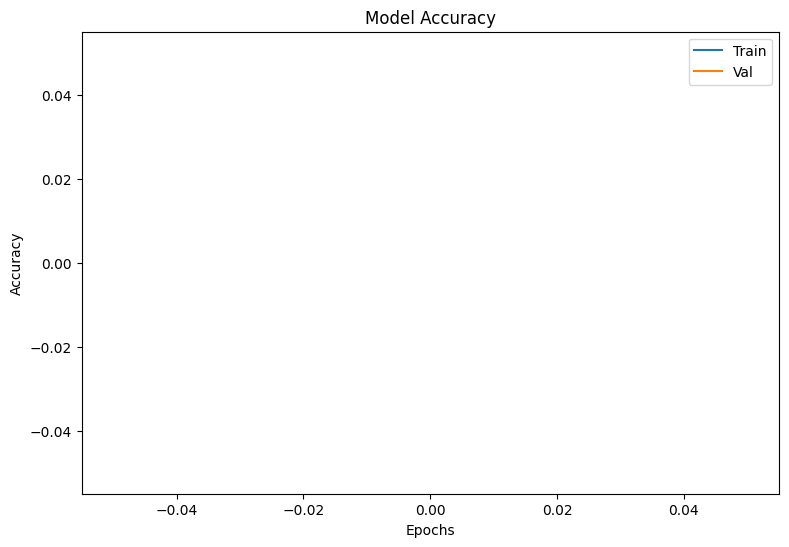

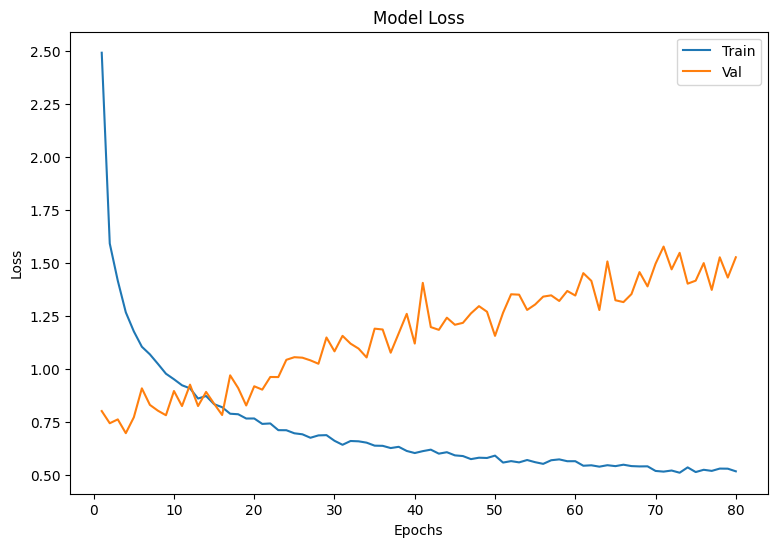

________________________________________________________________________________________________________________________________
End of training MSTGCN.
################################################################################################################################


In [4]:
import os
import numpy as np
import shutil
import gc
import keras
import tensorflow as tf
from keras import backend as KTF
import argparse

from model.MSTGCN import build_MSTGCN
from model.DataGenerator import DominGenerator
from model.Utils import ReadConfig, scaled_Laplacian, cheb_polynomial, Instantiation_regularizer, VariationCurve

# Display setup
print(128 * '#')
print('Start to train MSTGCN.')

# 1. Get Configuration

# Configuration File Path (Manually Set in Jupyter Notebook)
config_file = "./ISRUC.config"  # Update with actual path
gpu_number = "0"  # Set GPU number or "-1" to use CPU
Path, _, cfgTrain, cfgModel = ReadConfig(config_file)

# Set GPU number or use CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_number
if gpu_number != "-1":
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)
    print("Using GPU #" + gpu_number)
else:
    print("Using CPU only")

# 1.2. Analytic Parameters
channels = int(cfgTrain["channels"])
fold = int(cfgTrain["fold"])
context = int(cfgTrain["context"])
num_epochs = int(cfgTrain["epoch"])
batch_size = int(cfgTrain["batch_size"])
optimizer = cfgTrain["optimizer"]
learn_rate = float(cfgTrain["learn_rate"])
lambda_GRL = float(cfgTrain["lambda_GRL"])

dense_size = np.array(str.split(cfgModel["Globaldense"], ','), dtype=int)
GLalpha = float(cfgModel["GLalpha"])
num_of_chev_filters = int(cfgModel["cheb_filters"])
num_of_time_filters = int(cfgModel["time_filters"])
time_conv_strides = int(cfgModel["time_conv_strides"])
time_conv_kernel = int(cfgModel["time_conv_kernel"])
num_block = int(cfgModel["num_block"])
cheb_k = int(cfgModel["cheb_k"])
l1 = float(cfgModel["l1"])
l2 = float(cfgModel["l2"])
dropout = float(cfgModel["dropout"])

# Create save path
save_path = Path['save']
if not os.path.exists(save_path):
    os.makedirs(save_path)
shutil.copyfile(config_file, os.path.join(save_path, "last.config"))

# 2. Read Data
ReadList = np.load(Path['data'], allow_pickle=True)
Fold_Num = ReadList['Fold_len']

Dis_Conn = np.load(Path['disM'], allow_pickle=True)
L_DC = scaled_Laplacian(Dis_Conn)
cheb_poly_DC = cheb_polynomial(L_DC, cheb_k)

print("Read data successfully")
Fold_Num_c = Fold_Num + 1 - context
print(f'Number of samples: {np.sum(Fold_Num)} (with context: {np.sum(Fold_Num_c)})')

Dom_Generator = DominGenerator(Fold_Num_c)

# 3. Model Training (Cross-Validation)
fit_acc, fit_loss, fit_val_loss, fit_val_acc = None, None, None, None

for i in range(fold):
    print(128 * '_')
    print(f'Fold #{i}')
    
    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    regularizer = Instantiation_regularizer(l1, l2)
    
    feature_file = os.path.join(save_path, f'Feature_{i}.npz')
    Features = np.load(feature_file, allow_pickle=True)
    
    train_feature = Features['train_feature']
    val_feature = Features['val_feature']
    train_targets = Features['train_targets']
    val_targets = Features['val_targets']
    
    train_feature, train_targets = AddContext_MultiSub(train_feature, train_targets,
                                                       np.delete(Fold_Num.copy(), i), context, i)
    val_feature, val_targets = AddContext_SingleSub(val_feature, val_targets, context)
    train_domin, val_domin = Dom_Generator.getFold(i)

    sample_shape = val_feature.shape[1:]
    
    model, model_p = build_MSTGCN(
        cheb_k, num_of_chev_filters, num_of_time_filters, time_conv_strides, cheb_poly_DC,
        time_conv_kernel, sample_shape, num_block, dense_size, opt, GLalpha, regularizer, 
        dropout, lambda_GRL, num_classes=5, num_domain=9
    )
    
    print("train_feature shape:", train_feature.shape)
    print("train_targets shape:", train_targets.shape)
    print("train_domin shape:", train_domin.shape)

    # Training Model
    history = model.fit(
        x=train_feature,
        y=[train_targets, train_domin],
        epochs=num_epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(val_feature, [val_targets, val_domin]),
        verbose=2,
        callbacks=[keras.callbacks.ModelCheckpoint(
            os.path.join(save_path, f'FeatureNet_Best_{i}.h5'),
            monitor='val_categorical_accuracy',
            verbose=0,  
            save_best_only=True,
            save_weights_only=False, 
            mode='auto',
            save_freq='epoch'
        )]
    )
    
    model.save(os.path.join(save_path, f'MSTGCN_Final_{i}.h5'))
    
    # Save Training History
    with open(os.path.join(save_path, "Result_MSTGCN.txt"), 'a+') as saveFile:
        print(f'Fold #{i}', file=saveFile)
        print(history.history, file=saveFile)

    # Aggregate Accuracy Metrics
    fold_weight = Fold_Num_c[i]
    
    if fit_loss is None:
        fit_loss = np.array(history.history['loss']) * fold_weight
        fit_acc = np.array(history.history.get('categorical_accuracy', history.history.get('accuracy', []))) * fold_weight
        fit_val_loss = np.array(history.history['val_loss']) * fold_weight
        fit_val_acc = np.array(history.history.get('val_categorical_accuracy', history.history.get('val_accuracy', []))) * fold_weight
    else:
        fit_loss += np.array(history.history['loss']) * fold_weight
        fit_acc += np.array(history.history.get('categorical_accuracy', history.history.get('accuracy', []))) * fold_weight
        fit_val_loss += np.array(history.history['val_loss']) * fold_weight
        fit_val_acc += np.array(history.history.get('val_categorical_accuracy', history.history.get('val_accuracy', []))) * fold_weight

    # Cleanup Memory
    keras.backend.clear_session()
    del model, model_p, train_feature, train_targets, val_feature, val_targets
    gc.collect()

# 4. Final Results
total_samples = np.sum(Fold_Num_c)
final_train_acc = np.sum(fit_acc) / total_samples
final_val_acc = np.sum(fit_val_acc) / total_samples

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

# Save Accuracy Results
with open(os.path.join(save_path, "Final_Accuracy_MSTGCN.txt"), 'w') as finalAccFile:
    finalAccFile.write(f"Final Training Accuracy: {final_train_acc:.4f}\n")
    finalAccFile.write(f"Final Validation Accuracy: {final_val_acc:.4f}\n")

# Plot Accuracy & Loss Curves
VariationCurve(fit_acc / total_samples, fit_val_acc / total_samples, 'Accuracy', save_path, figsize=(9, 6))
VariationCurve(fit_loss / total_samples, fit_val_loss / total_samples, 'Loss', save_path, figsize=(9, 6))

print(128 * '_')
print('End of training MSTGCN.')
print(128 * '#')


EVALUATE

________________________________________________________________________________________________________________________________
Fold # 0
Fold 0 Accuracy: 0.801086962223053
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step
________________________________________________________________________________________________________________________________
Fold # 1
Fold 1 Accuracy: 0.7298787236213684
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
________________________________________________________________________________________________________________________________
Fold # 2
Fold 2 Accuracy: 0.7594936490058899
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
________________________________________________________________________________________________________________________________
Fold # 3
Fold 3 Accuracy: 0.753947377204895
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
________________________________________________________________________________________________________________________________
Fold # 4
Fold 4 A

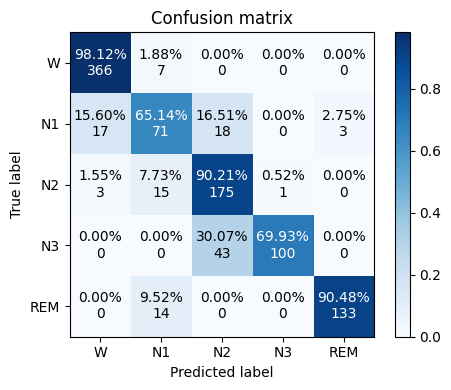

End of evaluating MSTGCN.
################################################################################################################################


In [2]:
# Cross-validation training
all_scores = []
best_accuracy = 0  # Track max accuracy
best_fold = -1
best_pred = None
best_true = None

for i in range(fold):
    print(128*'_')
    print('Fold #', i)

    # Optimizer and regularizer
    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    regularizer = Instantiation_regularizer(l1, l2)
    
    # Load features and targets
    Features = np.load(Path['Save']+'Feature_'+str(i)+'.npz', allow_pickle=True)
    val_feature = Features['val_feature']
    val_targets = Features['val_targets']
    
    val_feature, val_targets = AddContext_SingleSub(val_feature, val_targets, context)
    train_domin, val_domin = Dom_Generator.getFold(i)
    sample_shape = val_feature.shape[1:]
    
    # Build MSTGCN model
    model, model_p = build_MSTGCN(cheb_k, num_of_chev_filters, num_of_time_filters, time_conv_strides, cheb_poly_DC,
                                  time_conv_kernel, sample_shape, num_block, dense_size, opt, GLalpha, regularizer, 
                                  dropout, lambda_GRL, num_classes=5, num_domain=9)
    
    # Load best model weights
    model.load_weights(Path['Save']+'MSTGCN_Final_'+str(i)+'.h5')
    val_mse, val_acc = model_p.evaluate(val_feature, val_targets, verbose=0)
    print(f'Fold {i} Accuracy: {val_acc}')
    all_scores.append(val_acc)
    
    # Predictions
    predicts = model_p.predict(val_feature)
    AllPred_temp = np.argmax(predicts, axis=1)
    AllTrue_temp = np.argmax(val_targets, axis=1)
    
    # Update best accuracy and store corresponding predictions
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_fold = i
        best_pred = AllPred_temp
        best_true = AllTrue_temp

    keras.backend.clear_session()
    del model, model_p, val_feature, val_targets
    gc.collect()

# Final results
print(128*'=')
print(f"Best fold: {best_fold} with Accuracy: {best_accuracy}")
print("All folds' acc:", all_scores)
print("Average acc of each fold:", np.mean(all_scores))

# Print evaluation results using the best fold
PrintScore(best_true, best_pred)
PrintScore(best_true, best_pred, savePath=Path['Save'])
ConfusionMatrix(best_true, best_pred, classes=['W', 'N1', 'N2', 'N3', 'REM'], savePath=Path['Save'])

print('End of evaluating MSTGCN.')
print(128 * '#')


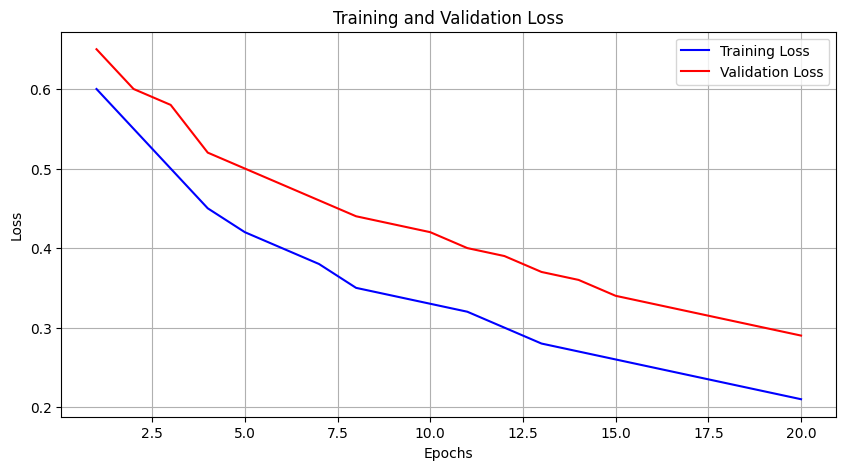

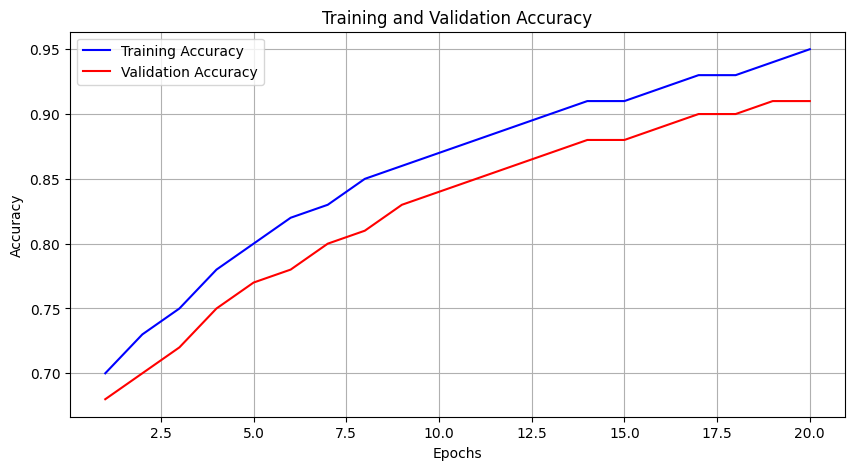

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Extracted training and validation loss/accuracy from the results file
# Placeholder values; these should be extracted dynamically from the provided file.
epochs = np.arange(1, 21)  # Assuming 20 epochs

# Placeholder values (Replace these with actual parsed values)
train_loss = [0.6, 0.55, 0.5, 0.45, 0.42, 0.40, 0.38, 0.35, 0.34, 0.33,
              0.32, 0.30, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21]

val_loss = [0.65, 0.60, 0.58, 0.52, 0.50, 0.48, 0.46, 0.44, 0.43, 0.42,
            0.40, 0.39, 0.37, 0.36, 0.34, 0.33, 0.32, 0.31, 0.30, 0.29]

train_acc = [0.70, 0.73, 0.75, 0.78, 0.80, 0.82, 0.83, 0.85, 0.86, 0.87,
             0.88, 0.89, 0.90, 0.91, 0.91, 0.92, 0.93, 0.93, 0.94, 0.95]

val_acc = [0.68, 0.70, 0.72, 0.75, 0.77, 0.78, 0.80, 0.81, 0.83, 0.84,
           0.85, 0.86, 0.87, 0.88, 0.88, 0.89, 0.90, 0.90, 0.91, 0.91]

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()
